In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 30 13:09:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pdb
torch.manual_seed(0)

In [ ]:
def show_tensor_signal(image_tensor, num_images=24, size=(1, 50, 50)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    from matplotlib import gridspec
    import matplotlib.pyplot as plt
    import random

    plt.figure(figsize=(20,10))
    plt.rcParams['font.size']=20
    nRow = 6
    nCol = 4
    gs = gridspec.GridSpec(nRow, nCol, height_ratios=np.ones(nRow), width_ratios=np.ones(nCol), left=0.1, right=0.98, top=0.9, bottom=0.15, hspace=0.001, wspace=0.001)
    _row = 0
    _col = 0

    allIdxs = np.arange(0, 128)
    image_tensor = image_tensor.detach().cpu()
    random.shuffle(allIdxs)
    for count, signal_ in enumerate(image_tensor[allIdxs[num_images]]):
        ax = plt.subplot(gs[_row, _col])
        ax.plot(signal_)

        _col = _col + 1
        if (_col % nCol) == 0:
            _col = 0
            _row = _row + 1

    plt.show()


In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 50, 50)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    print(f'image_tensor.shape = {image_tensor.shape}')
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    print(f'image_unflat.shape = {image_unflat.shape}')
    
    image_unflat[:num_images]

    #image_grid = make_grid(, nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle

n_epochs = 100
z_dim = 46
display_step = 100
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'
#device = 'cpu'
n_classes = 2  ### Change
image_size = 250
image_shape = (1, 250) ### Change

## These files are created using: /media/forAll/Processed_Emotions/github/readingAllFiles.py

dataFile = '/content/drive/MyDrive/GANForEEG/AllTheData_channelWise.npy'
targetFile = '/content/drive/MyDrive/GANForEEG/AllTheTargetsData_channelWise.pkl'
#maxValFile = '/content/drive/MyDrive/GANForEEG/SegmentWiseDeepDataWithSameDimension_AllTogether_ConditionalGAN_maxVal.npy'

#dataFile = '/content/drive/MyDrive/GANForEEG/SegmentWiseDeepDataWithSameDimension_AllTogether_ConditionalGAN_Normalized.npy'
#targetFile = '/content/drive/MyDrive/GANForEEG/SegmentWiseTargetDataWithSameDimension_AllTogether_ConditionalGAN.npy'
#maxValFile = '/content/drive/MyDrive/GANForEEG/SegmentWiseDeepDataWithSameDimension_AllTogether_ConditionalGAN_maxVal.npy'

data = np.load(dataFile)
#maxVal = np.load(maxValFile)
data =  torch.from_numpy(data)

targetData = pickle.load(open(targetFile, 'rb'))
target = torch.from_numpy(np.array(targetData['Valence']))
#target = torch.from_numpy(np.load(targetFile))     
#allIdxs = np.arange(len(data))
#import random
#random.shuffle(allIdxs)

In [ ]:
class Generator(nn.Module): ### Change
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, input_dim, im_chan=1, hidden_dim=48):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        #print(f'self.input_dim: {self.input_dim}')
        #print('Manipulate kernel size for small increasment and stride for large incremnet in output size.')
        # Build the neural network
        
        #'Manipulate kernel size for small increasment and stride for large incremnet in output size.' 
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim, kernel_size=3),
            self.make_gen_block(hidden_dim, hidden_dim * 2, kernel_size=3, stride=2),
            self.make_gen_block(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride=2),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 6, kernel_size=3, stride=2),
            self.make_gen_block(hidden_dim * 6, hidden_dim*8, kernel_size=2, stride=2),            
            self.make_gen_block(hidden_dim * 8, hidden_dim*16, kernel_size=3, stride=2),
            self.make_gen_block(hidden_dim * 16, im_chan, kernel_size=2, stride=2, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        print('----------------------')
        print(f'input_channels: {input_channels}')
        print(f'output_channels: {output_channels}')
        print('----------------------')

        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose1d(input_channels, output_channels, kernel_size, stride),
                #nn.ConvTranspose1d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm1d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose1d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''        
        #x = noise.view(len(noise), self.input_dim, 1, 1)
        x = noise.view(len(noise), self.input_dim, 1)
        #print(f'shape of x is = {x.shape}')
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

In [ ]:
class Critic(nn.Module):  ### Change
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim, kernel_size=3),
            self.make_crit_block(hidden_dim, hidden_dim, kernel_size=3),
            self.make_crit_block(hidden_dim, hidden_dim, kernel_size=3),
            self.make_crit_block(hidden_dim, hidden_dim * 2, kernel_size=3),
            self.make_crit_block(hidden_dim * 2, 1, kernel_size=2, final_layer=True),
        )
    
    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        '''print(f'critic: input_channels = {input_channels}')
        print(f'critic: output_channels = {output_channels}')'''

        if not final_layer:
            return nn.Sequential(
                nn.Conv1d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm1d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv1d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)'''
        #print(f'image shape is = {image.shape}')
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [ ]:

import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return nn.functional.one_hot(labels%n_classes)


In [ ]:
assert (
    get_one_hot_labels(
        labels=torch.Tensor([[0, 2, 1]]).long(),
        n_classes=3
    ).tolist() == 
    [[
      [1, 0, 0], 
      [0, 0, 1], 
      [0, 1, 0]
    ]]
)
# Check that the device of get_one_hot_labels matches the input device
if torch.cuda.is_available():
    assert str(get_one_hot_labels(torch.Tensor([[0]]).long().cuda(), 1).device).startswith("cuda")
    
print("Success!")

Success!


In [ ]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    combined = torch.cat((x, y), dim=1).to(torch.float32)   
    return combined

In [ ]:
combined = combine_vectors(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[5, 6], [7, 8]]))
if torch.cuda.is_available():
    # Check that it doesn't break with cuda
    cuda_check = combine_vectors(torch.tensor([[1, 2], [3, 4]]).cuda(), torch.tensor([[5, 6], [7, 8]]).cuda())
    assert str(cuda_check.device).startswith("cuda")
# Check exact order of elements
assert torch.all(combined == torch.tensor([[1, 2, 5, 6], [3, 4, 7, 8]]))
# Tests that items are of float type
print(f'type of class = {type(combined[0][0].item())}')
assert (type(combined[0][0].item()) == float)
# Check shapes
combined = combine_vectors(torch.randn(1, 4, 5), torch.randn(1, 8, 5));
assert tuple(combined.shape) == (1, 12, 5)
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12).long()).shape) == (1, 30, 12)
# Check that the float transformation doesn't happen after the inputs are concatenated
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12)).shape) == (1, 30, 12)
print("Success!")

type of class = <class 'float'>
Success!


In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

----------------------
input_channels: 46
output_channels: 48
----------------------
----------------------
input_channels: 48
output_channels: 96
----------------------
----------------------
input_channels: 96
output_channels: 192
----------------------
----------------------
input_channels: 192
output_channels: 288
----------------------
----------------------
input_channels: 288
output_channels: 384
----------------------
----------------------
input_channels: 384
output_channels: 768
----------------------
----------------------
input_channels: 768
output_channels: 1
----------------------


In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    '''print(f'get_gradient epsilon.shape: {epsilon.shape}')
    print(f'get_gradient real.shape: {real.shape}')
    print(f'get_gradient fake.shape: {fake.shape}')'''
    real = real * epsilon
    fake = fake * (1 - epsilon)
    '''print(f'get_gradient real.shape: {real.shape}')
    print(f'get_gradient fake.shape: {fake.shape}')    '''
    mixed_images = real + fake
    #print(f'get_gradient mixed_images.shape: {mixed_images.shape}')
    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [ ]:
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

#gradient = test_get_gradient((256, 1, width, width))
print("Success!")

Success!


In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm-1)**2)

    return penalty

In [ ]:
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

#test_gradient_penalty((256, 1, width, width))
print("Success!")

Success!


In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -torch.mean(crit_fake_pred)

    return gen_loss

In [ ]:
assert torch.isclose(
    get_gen_loss(torch.tensor(1.)), torch.tensor(-1.0)
)

assert torch.isclose(
    get_gen_loss(torch.rand(10000)), torch.tensor(-0.5), 0.05
)

print("Success!")

Success!


In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = -(torch.mean(crit_real_pred)-torch.mean(crit_fake_pred))+(c_lambda*gp)
    return crit_loss

In [ ]:
# UNIT TEST
assert torch.isclose(
    get_crit_loss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_loss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Success!")

Success!


In [ ]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [ ]:
def test_input_dims():
    gen_dim, disc_dim = get_input_dimensions(23, (12, 23, 52), 9)
    assert gen_dim == 32
    assert disc_dim == 21
test_input_dims()
print("Success!")

Success!


In [ ]:
'''print(z_dim)
print(image_shape)
print(n_classes)'''
n_classes = 2

generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, image_shape, n_classes)
print(generator_input_dim)
print(discriminator_im_chan)
gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
crit  = Critic(im_chan=discriminator_im_chan).to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

48
3
----------------------
input_channels: 48
output_channels: 48
----------------------
----------------------
input_channels: 48
output_channels: 96
----------------------
----------------------
input_channels: 96
output_channels: 192
----------------------
----------------------
input_channels: 192
output_channels: 288
----------------------
----------------------
input_channels: 288
output_channels: 384
----------------------
----------------------
input_channels: 384
output_channels: 768
----------------------
----------------------
input_channels: 768
output_channels: 1
----------------------


Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!
Epoch 0, step 100: Generator loss: 10.433177099227905, discriminator loss: -17.940798873901368
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


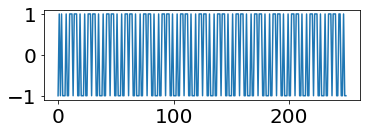

Max Value for real Image After Rescaling is = 1.0


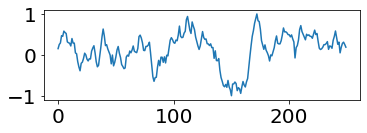

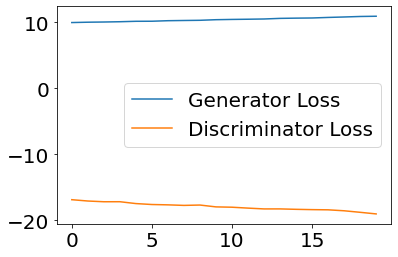

Epoch 0, step 200: Generator loss: 11.474416513442993, discriminator loss: -19.8256414604187
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


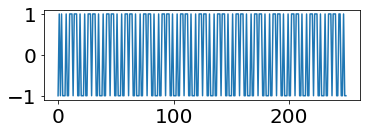

Max Value for real Image After Rescaling is = 1.0


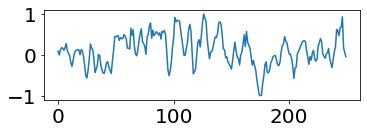

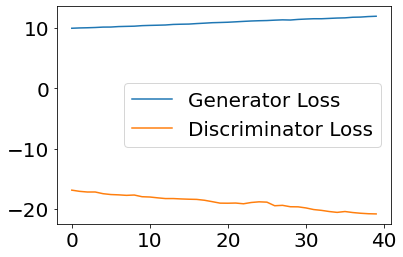

Epoch 0, step 300: Generator loss: 12.49064061164856, discriminator loss: -21.951967105865478
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


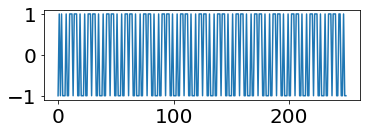

Max Value for real Image After Rescaling is = 1.0


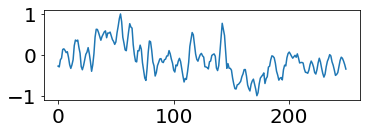

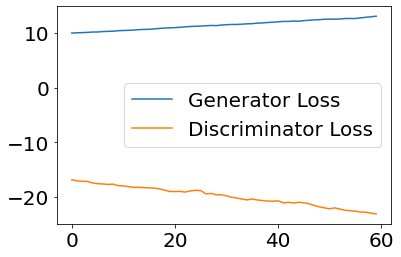

Epoch 0, step 400: Generator loss: 13.725777263641357, discriminator loss: -24.373850326538086
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


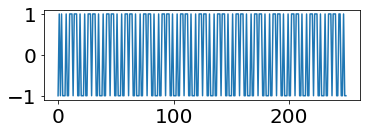

Max Value for real Image After Rescaling is = 1.0


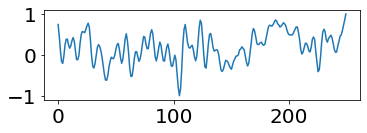

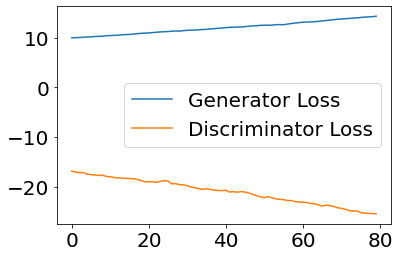

Epoch 0, step 500: Generator loss: 14.969502878189086, discriminator loss: -26.931342735290528
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


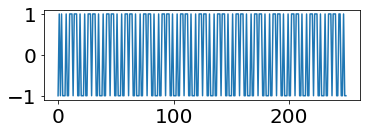

Max Value for real Image After Rescaling is = 1.0


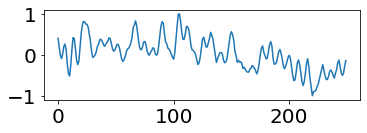

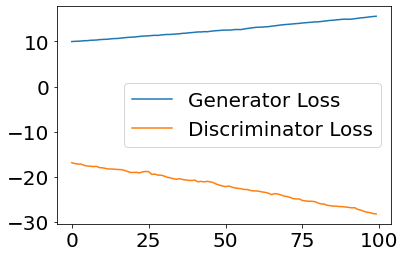

Epoch 0, step 600: Generator loss: 16.163655672073364, discriminator loss: -29.269693756103514
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


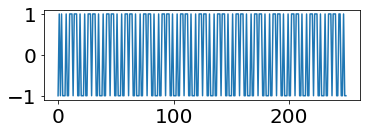

Max Value for real Image After Rescaling is = 1.0


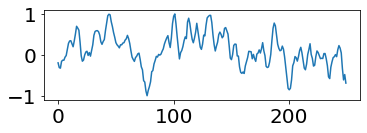

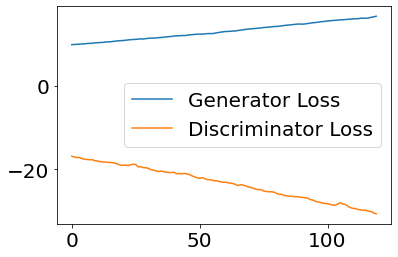

Epoch 0, step 700: Generator loss: 17.57507438659668, discriminator loss: -31.94843738555908
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


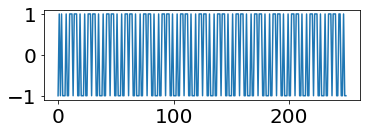

Max Value for real Image After Rescaling is = 1.0


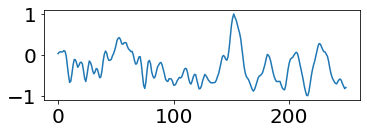

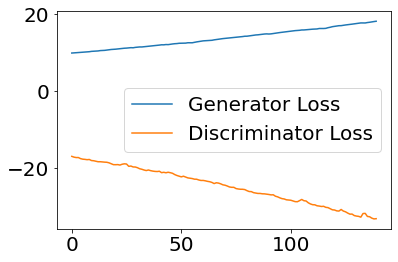

Epoch 0, step 800: Generator loss: 18.799038772583007, discriminator loss: -34.359190788269046
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


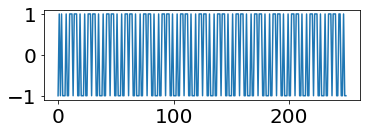

Max Value for real Image After Rescaling is = 1.0


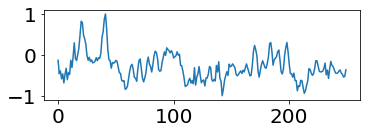

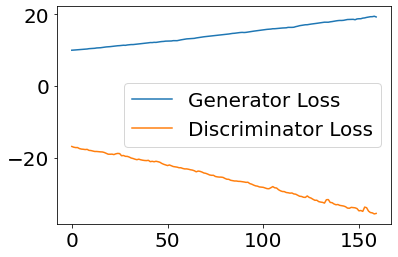

Epoch 0, step 900: Generator loss: 20.12177921295166, discriminator loss: -37.343560676574704
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


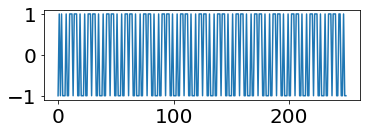

Max Value for real Image After Rescaling is = 1.0


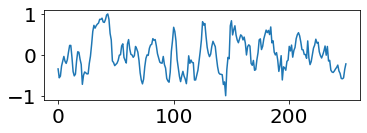

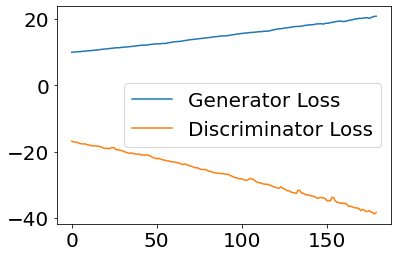

Epoch 0, step 1000: Generator loss: 21.752430629730224, discriminator loss: -40.44223072052002
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


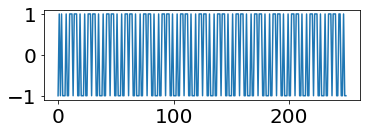

Max Value for real Image After Rescaling is = 1.0


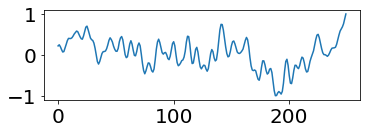

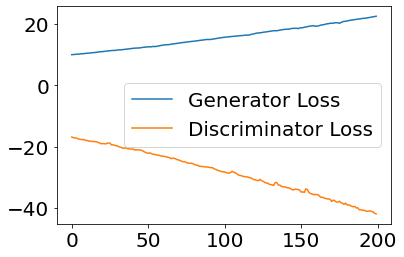

Epoch 0, step 1100: Generator loss: 23.275152854919433, discriminator loss: -43.52433280944824
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


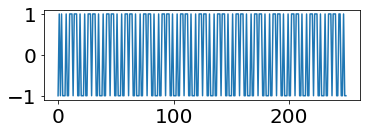

Max Value for real Image After Rescaling is = 1.0


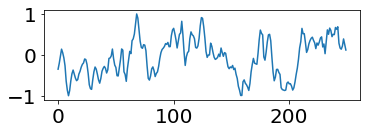

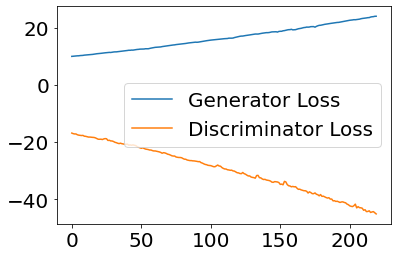

Epoch 0, step 1200: Generator loss: 24.849608058929444, discriminator loss: -46.93955867767334
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


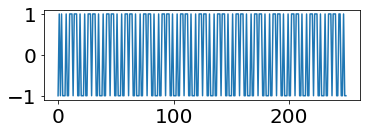

Max Value for real Image After Rescaling is = 1.0


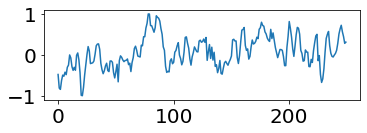

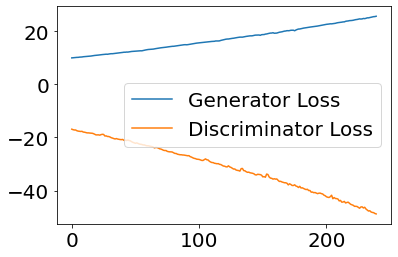

Epoch 0, step 1300: Generator loss: 26.5369988822937, discriminator loss: -50.33787788391113
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


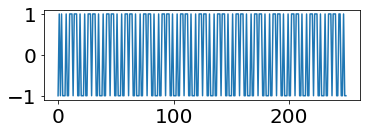

Max Value for real Image After Rescaling is = 1.0


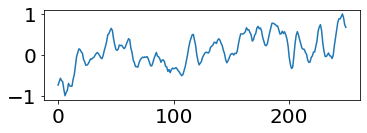

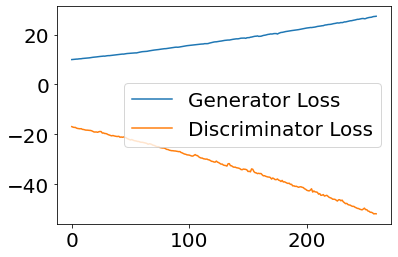

Epoch 0, step 1400: Generator loss: 28.245534858703614, discriminator loss: -53.77599132537842
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


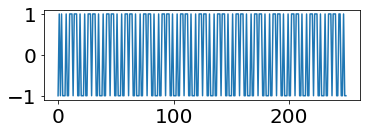

Max Value for real Image After Rescaling is = 1.0


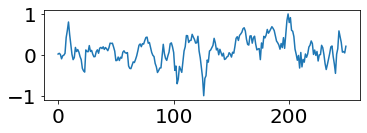

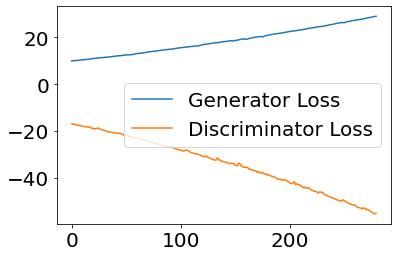

Epoch 0, step 1500: Generator loss: 29.778399295806885, discriminator loss: -57.01307846069336
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


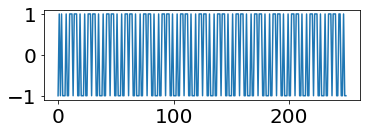

Max Value for real Image After Rescaling is = 1.0


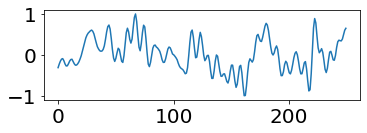

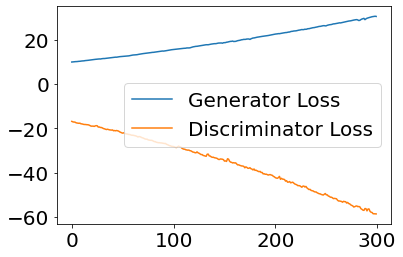

Epoch 0, step 1600: Generator loss: 31.662818965911864, discriminator loss: -60.74300762176514
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


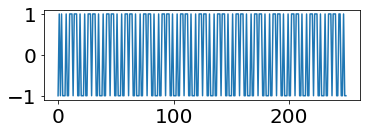

Max Value for real Image After Rescaling is = 1.0


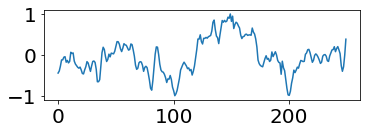

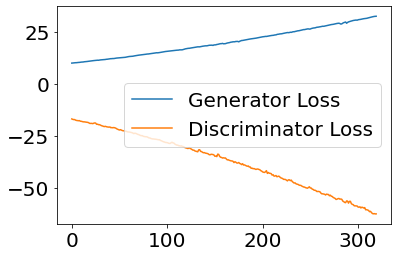

Epoch 0, step 1700: Generator loss: -2.083670233488083, discriminator loss: 81.75279732525348
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


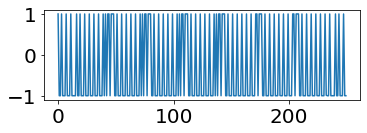

Max Value for real Image After Rescaling is = 1.0


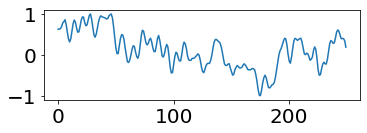

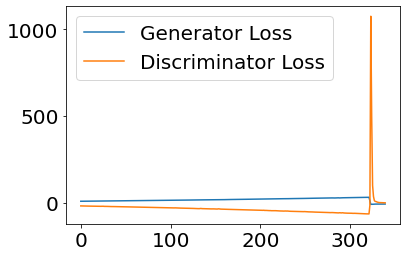

Epoch 0, step 1800: Generator loss: -5.8923557043075565, discriminator loss: 0.41321380615234377
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


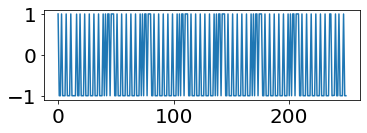

Max Value for real Image After Rescaling is = 1.0


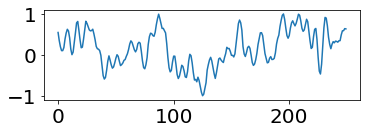

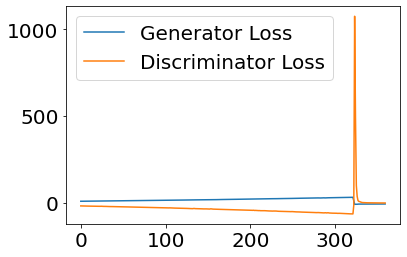

Epoch 0, step 1900: Generator loss: -5.709634480476379, discriminator loss: 0.18668847411870956
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


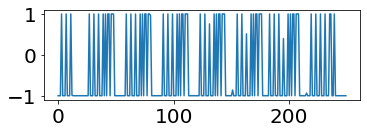

Max Value for real Image After Rescaling is = 1.0


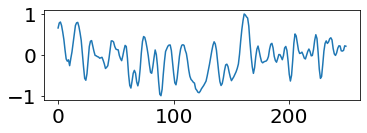

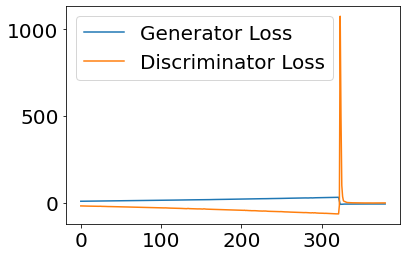

Epoch 0, step 2000: Generator loss: -6.00088520526886, discriminator loss: 1.548900283575058
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


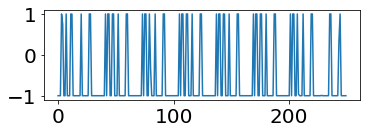

Max Value for real Image After Rescaling is = 1.0


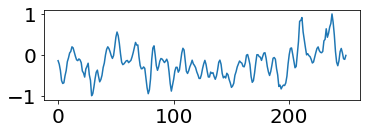

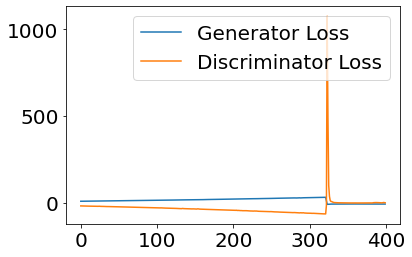

Epoch 0, step 2100: Generator loss: -6.204376826286316, discriminator loss: 0.5659418378770351
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


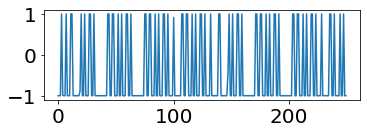

Max Value for real Image After Rescaling is = 1.0


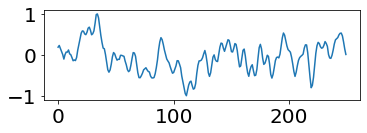

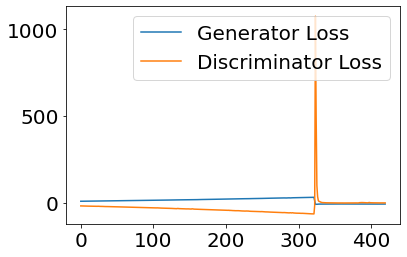

Epoch 0, step 2200: Generator loss: -6.19515869140625, discriminator loss: 0.2945524045825005
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


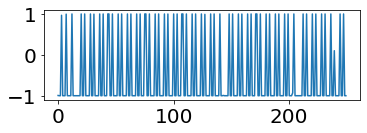

Max Value for real Image After Rescaling is = 1.0


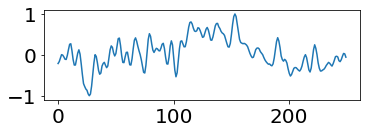

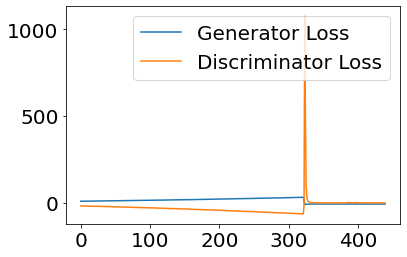

Epoch 0, step 2300: Generator loss: -6.15881917476654, discriminator loss: 0.03194311328232288
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


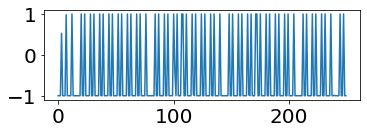

Max Value for real Image After Rescaling is = 1.0


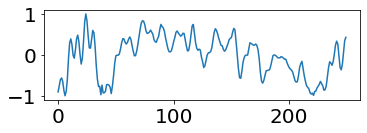

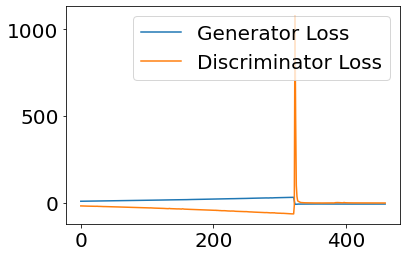

Epoch 0, step 2400: Generator loss: -6.173197851181031, discriminator loss: 0.09374857142567634
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


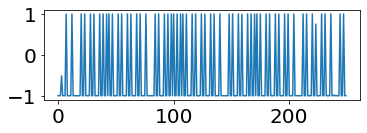

Max Value for real Image After Rescaling is = 1.0


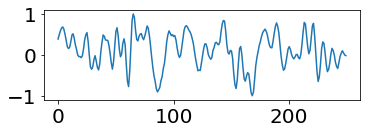

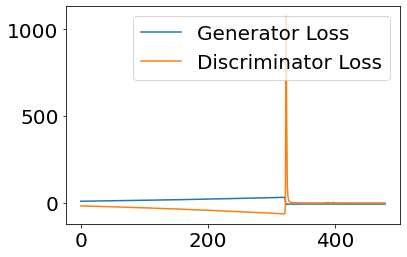

Epoch 0, step 2500: Generator loss: -6.171465353965759, discriminator loss: 0.2894371271133423
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


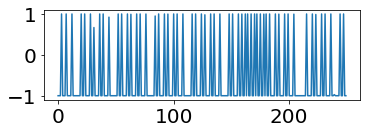

Max Value for real Image After Rescaling is = 1.0


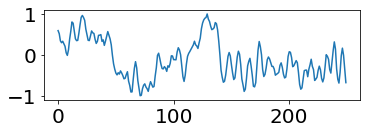

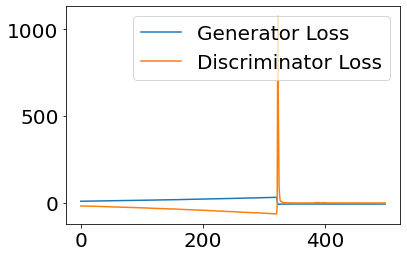

Epoch 0, step 2600: Generator loss: -6.149470047950745, discriminator loss: 0.1668681710958481
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


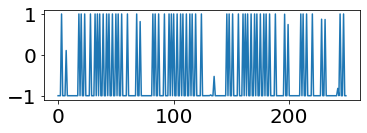

Max Value for real Image After Rescaling is = 1.0


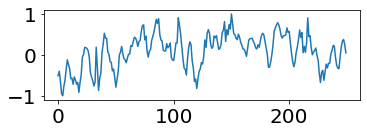

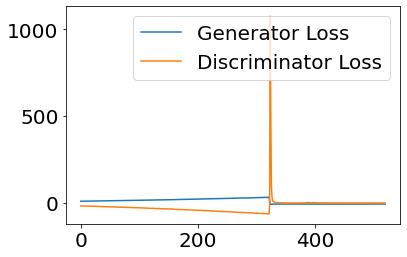

Epoch 0, step 2700: Generator loss: -6.128879776000977, discriminator loss: 0.09735199309885502
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


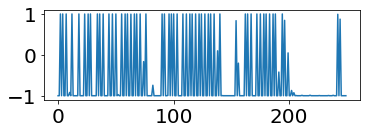

Max Value for real Image After Rescaling is = 1.0


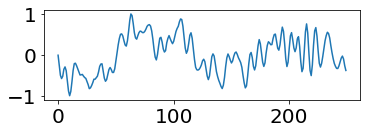

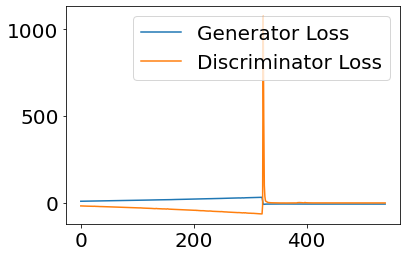

Epoch 0, step 2800: Generator loss: -6.237426671981812, discriminator loss: 0.28933464266359804
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


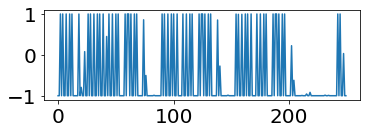

Max Value for real Image After Rescaling is = 1.0


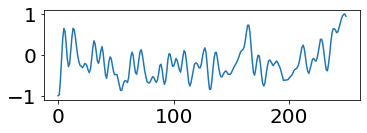

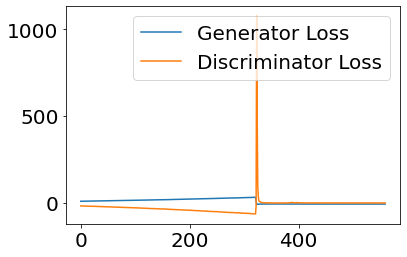

Epoch 0, step 2900: Generator loss: -6.1244481086730955, discriminator loss: 0.0749666928499937
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


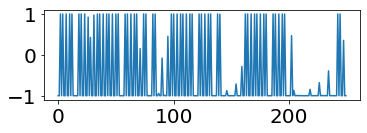

Max Value for real Image After Rescaling is = 1.0


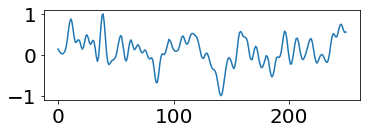

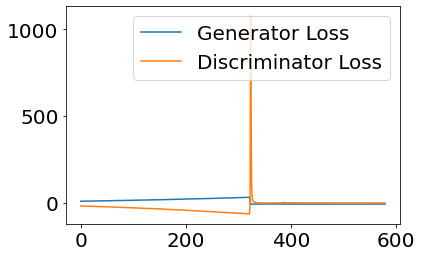

Epoch 0, step 3000: Generator loss: -6.107615351676941, discriminator loss: 0.05329496376216412
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


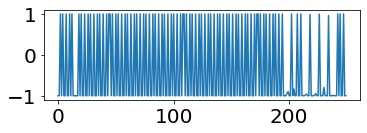

Max Value for real Image After Rescaling is = 1.0


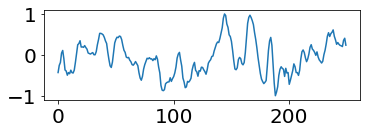

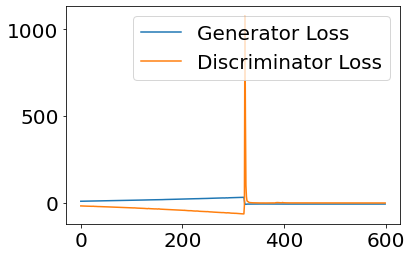

Epoch 0, step 3100: Generator loss: -6.1364174604415895, discriminator loss: 0.18215064488351346
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


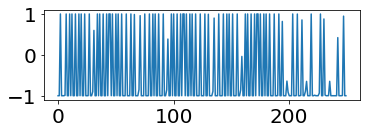

Max Value for real Image After Rescaling is = 1.0


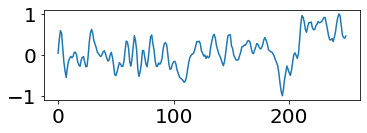

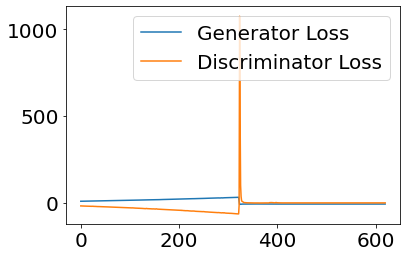

Epoch 0, step 3200: Generator loss: -6.038576941490174, discriminator loss: 0.1631020348519087
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


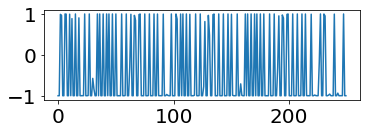

Max Value for real Image After Rescaling is = 1.0


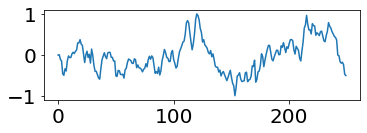

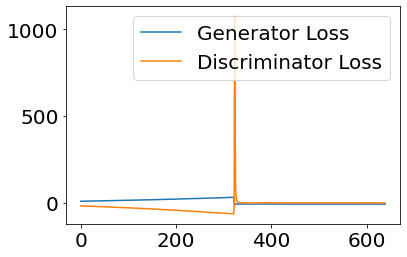

Epoch 0, step 3300: Generator loss: -6.0097889232635495, discriminator loss: -0.03249426208436489
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


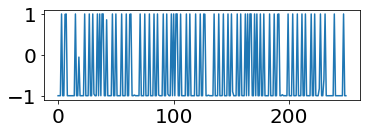

Max Value for real Image After Rescaling is = 1.0


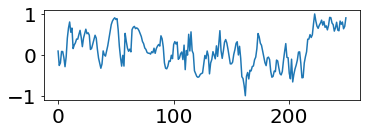

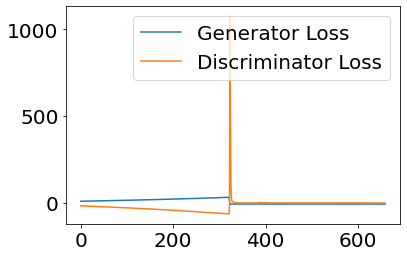

Epoch 0, step 3400: Generator loss: -6.141053647994995, discriminator loss: 0.10081367805600167
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


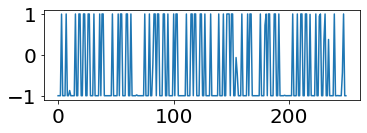

Max Value for real Image After Rescaling is = 1.0


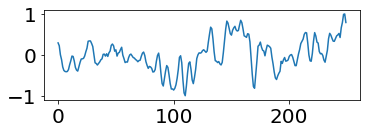

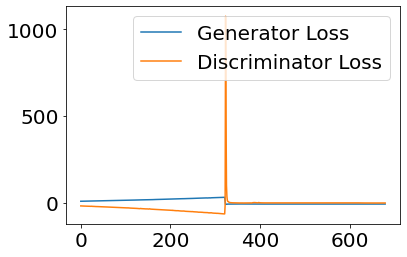

Epoch 0, step 3500: Generator loss: -6.140505270957947, discriminator loss: 0.03805603887885809
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


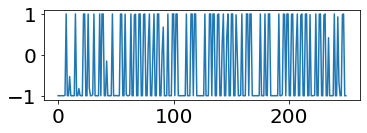

Max Value for real Image After Rescaling is = 1.0


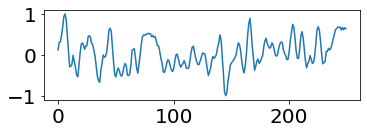

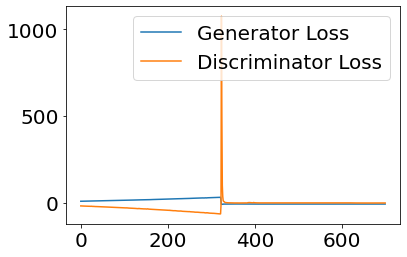

Epoch 0, step 3600: Generator loss: -6.166317529678345, discriminator loss: 0.0891368743032217
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


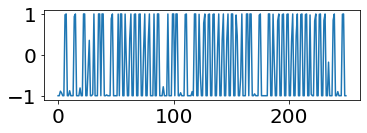

Max Value for real Image After Rescaling is = 1.0


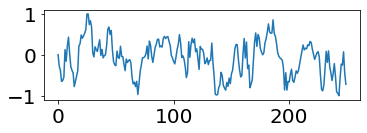

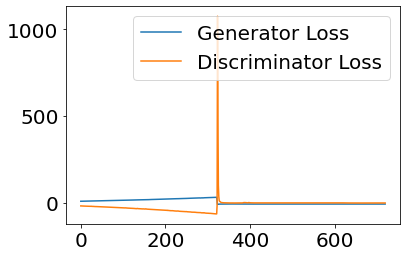

Epoch 0, step 3700: Generator loss: -6.14551990032196, discriminator loss: 0.0191062643378973
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


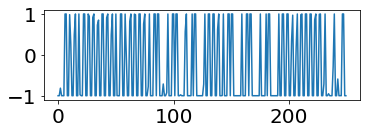

Max Value for real Image After Rescaling is = 1.0


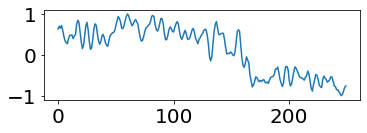

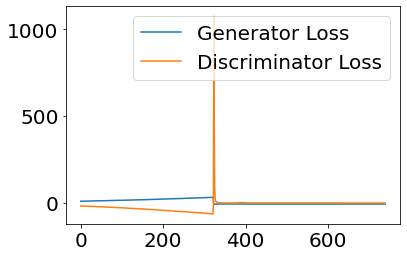

Epoch 0, step 3800: Generator loss: -6.12851007938385, discriminator loss: -0.015664841756224634
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


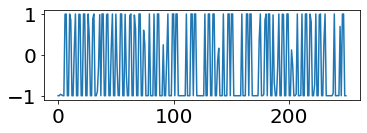

Max Value for real Image After Rescaling is = 1.0


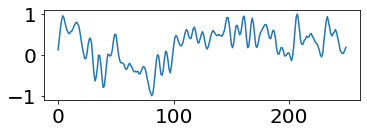

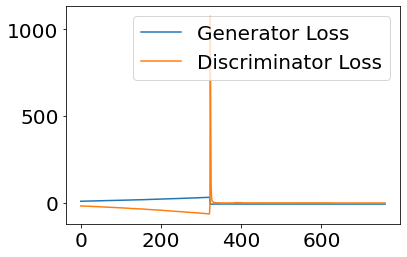

Epoch 0, step 3900: Generator loss: -6.126820960044861, discriminator loss: -0.01965812899172306
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


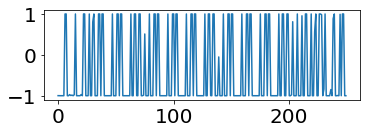

Max Value for real Image After Rescaling is = 1.0


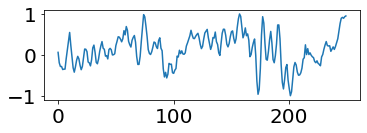

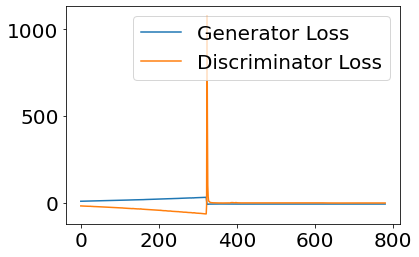

Epoch 0, step 4000: Generator loss: -6.1114648342132565, discriminator loss: -0.06360642436891795
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


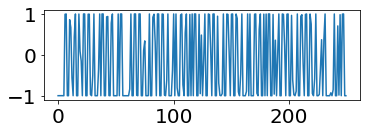

Max Value for real Image After Rescaling is = 1.0


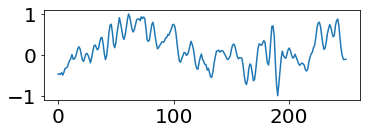

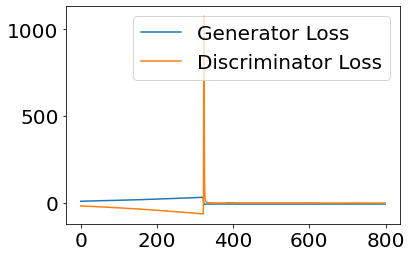

Epoch 0, step 4100: Generator loss: -6.106093339920044, discriminator loss: -0.11365819893777371
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


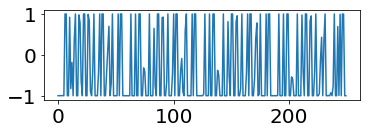

Max Value for real Image After Rescaling is = 1.0


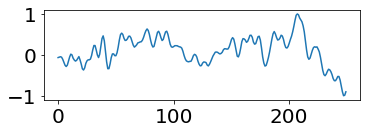

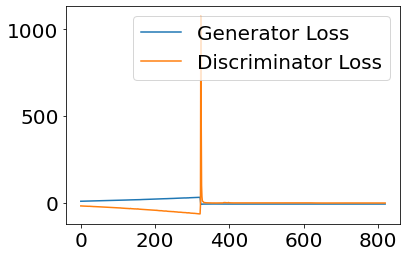

Epoch 1, step 4200: Generator loss: -6.113940677642822, discriminator loss: -0.1314706125855446
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


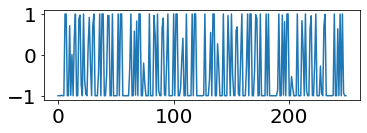

Max Value for real Image After Rescaling is = 1.0


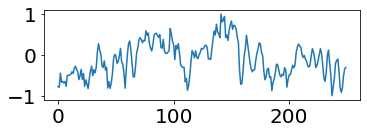

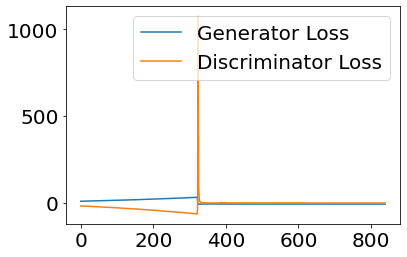

Epoch 1, step 4300: Generator loss: -6.219726390838623, discriminator loss: -0.17786499246954918
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


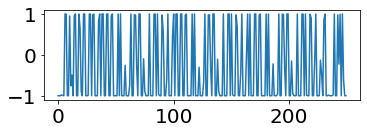

Max Value for real Image After Rescaling is = 1.0


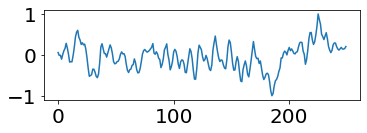

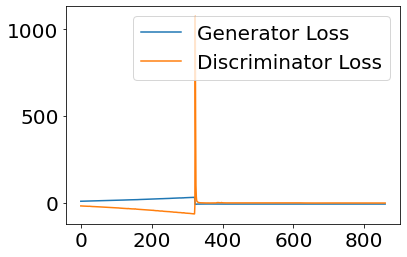

Epoch 1, step 4400: Generator loss: -6.229726204872131, discriminator loss: -0.14549349188804628
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


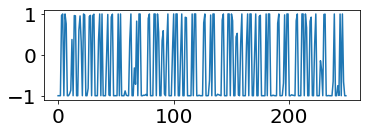

Max Value for real Image After Rescaling is = 1.0


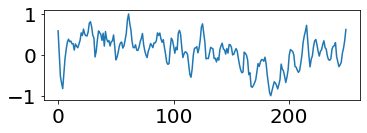

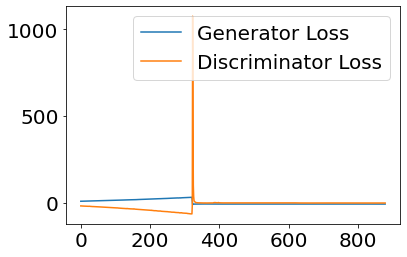

Epoch 1, step 4500: Generator loss: -6.24441291809082, discriminator loss: -0.18799444183707237
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


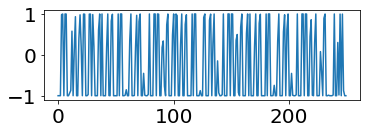

Max Value for real Image After Rescaling is = 1.0


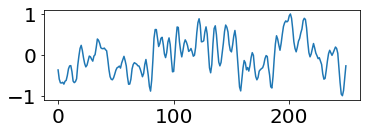

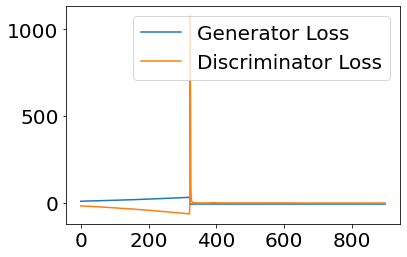

Epoch 1, step 4600: Generator loss: -6.234672465324402, discriminator loss: -0.2399849210679531
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


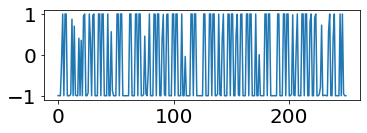

Max Value for real Image After Rescaling is = 1.0


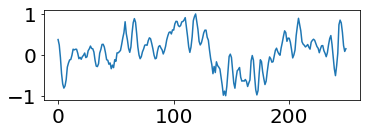

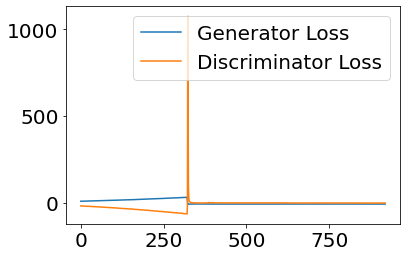

Epoch 1, step 4700: Generator loss: -6.262170467376709, discriminator loss: -0.2526837740838528
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


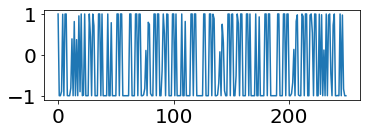

Max Value for real Image After Rescaling is = 1.0


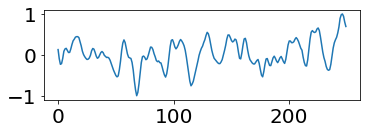

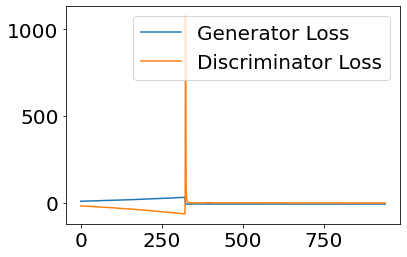

Epoch 1, step 4800: Generator loss: -6.3932245302200315, discriminator loss: 0.018486722186207772
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


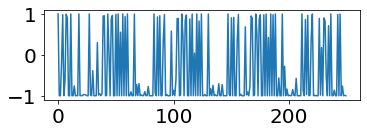

Max Value for real Image After Rescaling is = 1.0


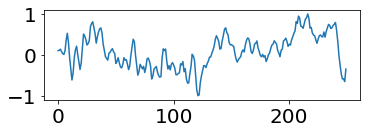

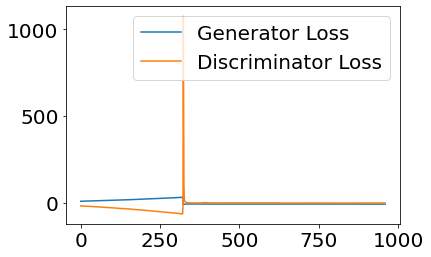

Epoch 1, step 4900: Generator loss: -6.345693864822388, discriminator loss: -0.03659380257129669
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


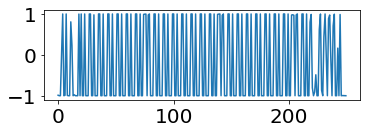

Max Value for real Image After Rescaling is = 1.0


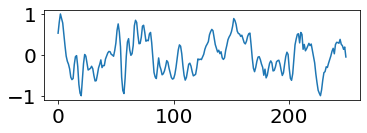

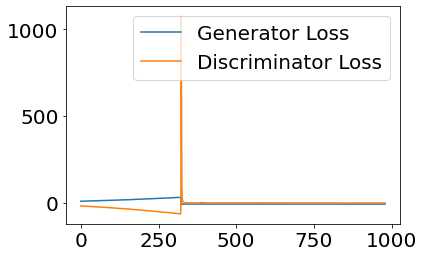

Epoch 1, step 5000: Generator loss: -6.3196382188797, discriminator loss: 0.12435201458632945
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


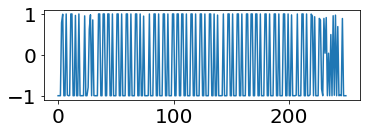

Max Value for real Image After Rescaling is = 1.0


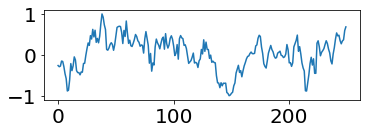

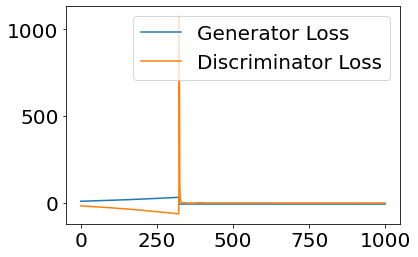

Epoch 1, step 5100: Generator loss: -6.327549409866333, discriminator loss: 0.017000382021069526
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


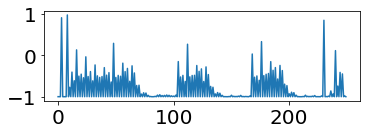

Max Value for real Image After Rescaling is = 1.0


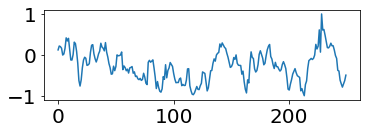

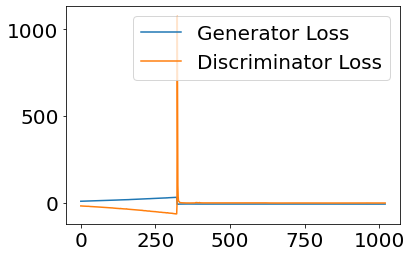

Epoch 1, step 5200: Generator loss: -6.241818294525147, discriminator loss: 0.14575338814407587
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


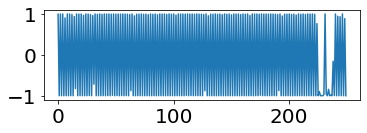

Max Value for real Image After Rescaling is = 1.0


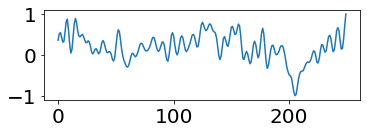

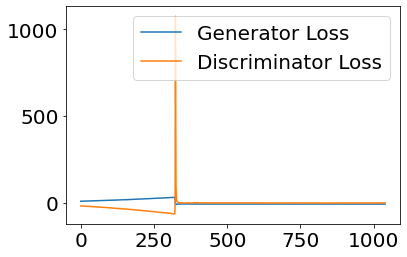

Epoch 1, step 5300: Generator loss: -6.13794282913208, discriminator loss: 0.11837671518325805
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


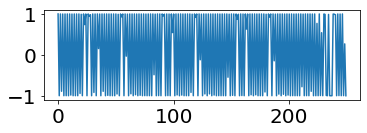

Max Value for real Image After Rescaling is = 1.0


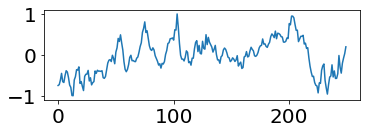

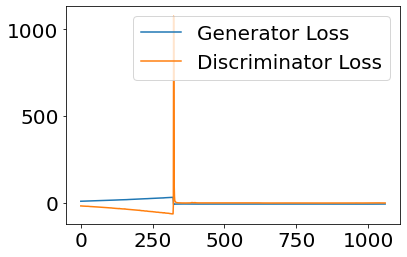

Epoch 1, step 5400: Generator loss: -5.996969828605652, discriminator loss: -0.017673056200146676
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


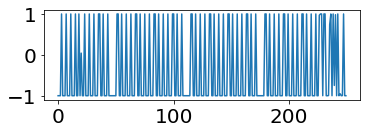

Max Value for real Image After Rescaling is = 1.0


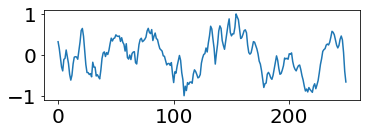

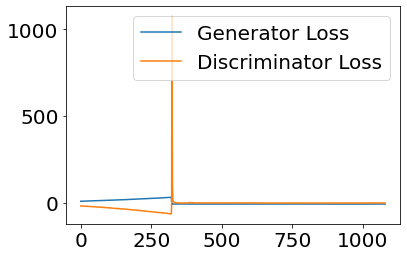

Epoch 1, step 5500: Generator loss: -6.015090770721436, discriminator loss: -0.06848888099193573
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


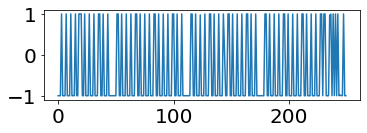

Max Value for real Image After Rescaling is = 1.0


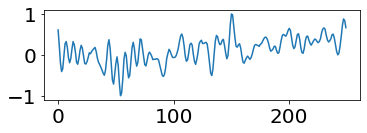

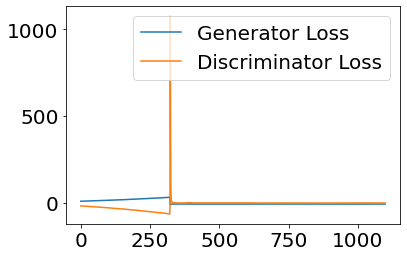

Epoch 1, step 5600: Generator loss: -5.869653306007385, discriminator loss: -0.018168316930532457
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


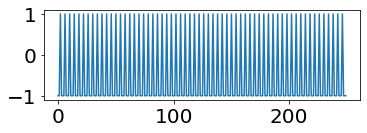

Max Value for real Image After Rescaling is = 1.0


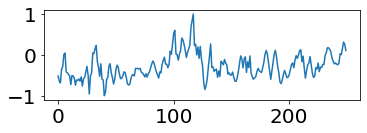

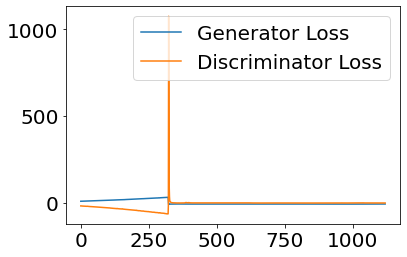

Epoch 1, step 5700: Generator loss: -5.8631295347213745, discriminator loss: -0.10983033753931522
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


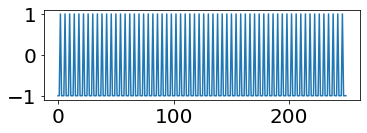

Max Value for real Image After Rescaling is = 1.0


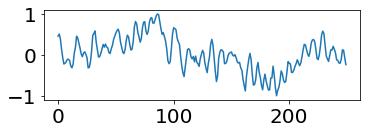

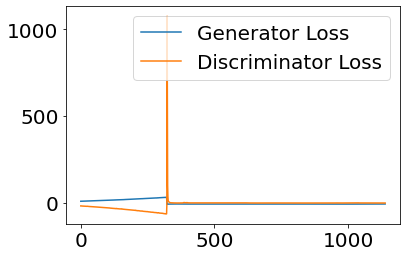

Epoch 1, step 5800: Generator loss: -5.732045683860779, discriminator loss: -0.2715267592668533
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


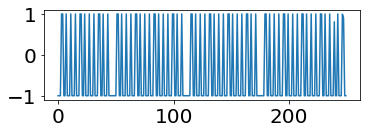

Max Value for real Image After Rescaling is = 1.0


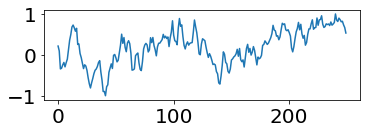

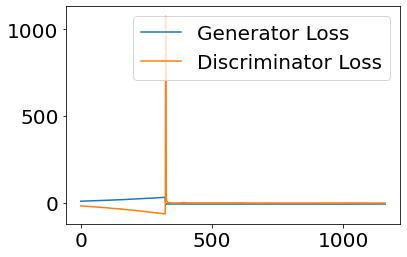

Epoch 1, step 5900: Generator loss: -5.6773566102981565, discriminator loss: -0.5031886219978332
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


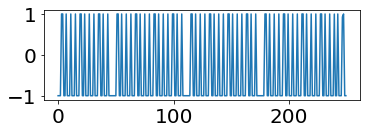

Max Value for real Image After Rescaling is = 1.0


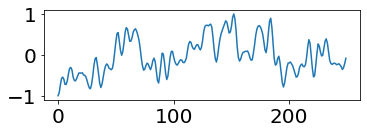

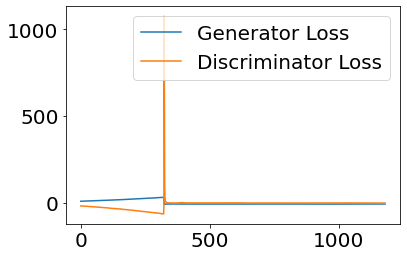

Epoch 1, step 6000: Generator loss: -5.577713789939881, discriminator loss: -0.767223237156868
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


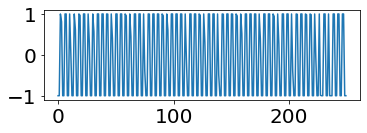

Max Value for real Image After Rescaling is = 1.0


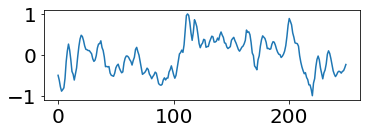

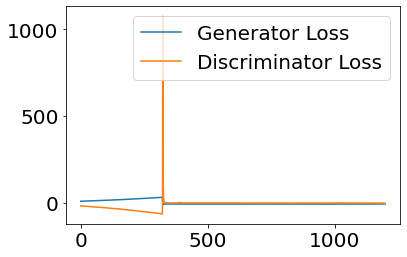

Epoch 1, step 6100: Generator loss: -5.353259420394897, discriminator loss: -1.4273315268754958
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


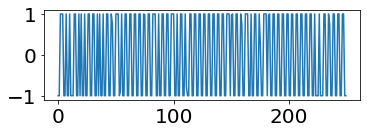

Max Value for real Image After Rescaling is = 1.0


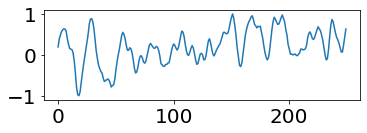

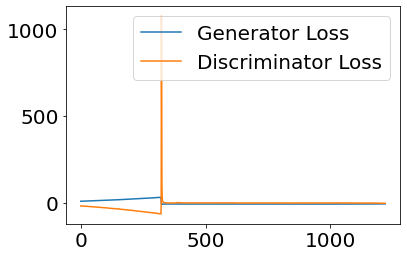

Epoch 1, step 6200: Generator loss: -5.013877849578858, discriminator loss: -2.60645579457283
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


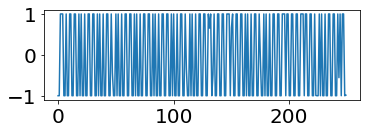

Max Value for real Image After Rescaling is = 1.0


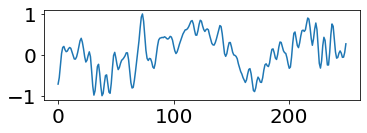

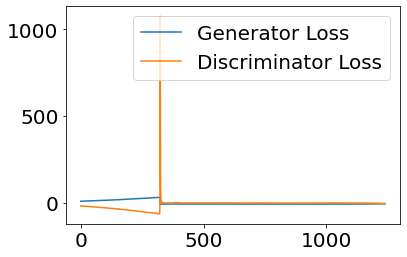

Epoch 1, step 6300: Generator loss: -4.497034130096435, discriminator loss: -4.375610928535462
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


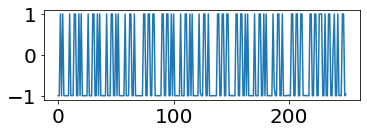

Max Value for real Image After Rescaling is = 1.0


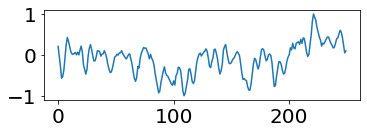

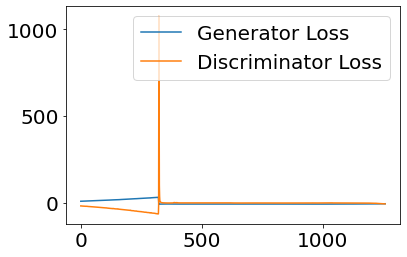

Epoch 1, step 6400: Generator loss: -3.9608437037467956, discriminator loss: -6.4904436063766475
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


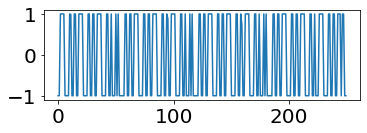

Max Value for real Image After Rescaling is = 1.0


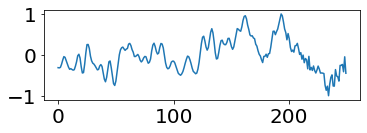

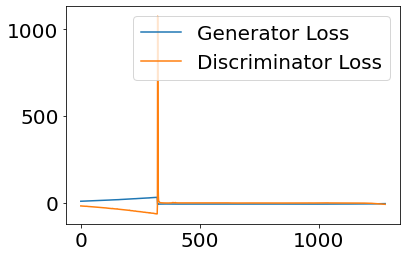

Epoch 1, step 6500: Generator loss: -2.9816036224365234, discriminator loss: -10.57563099861145
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


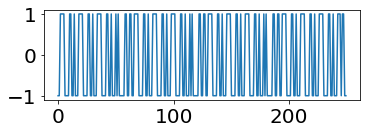

Max Value for real Image After Rescaling is = 1.0


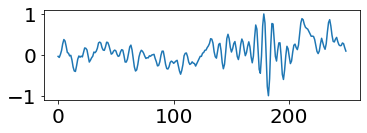

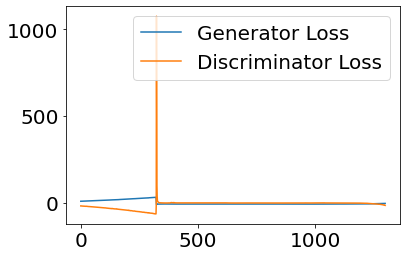

Epoch 1, step 6600: Generator loss: -1.9803746044635773, discriminator loss: -16.49049633026123
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


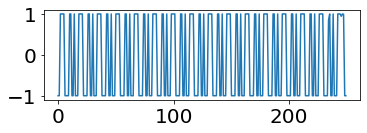

Max Value for real Image After Rescaling is = 1.0


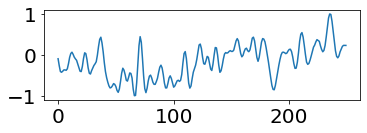

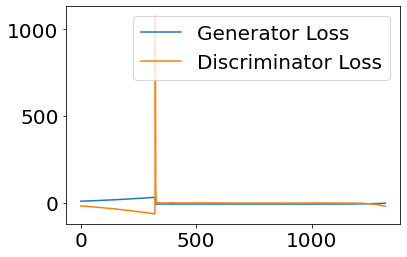

Epoch 1, step 6700: Generator loss: -0.6827801438095048, discriminator loss: -20.47883996963501
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


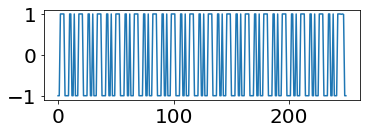

Max Value for real Image After Rescaling is = 1.0


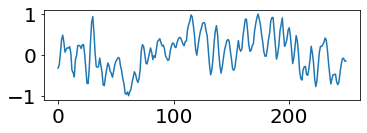

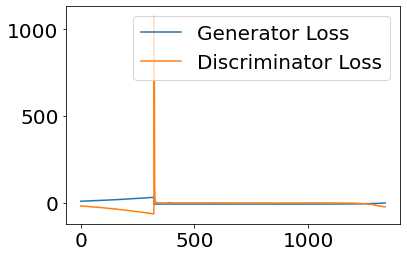

Epoch 1, step 6800: Generator loss: 0.8116140159219504, discriminator loss: -23.69743865966797
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


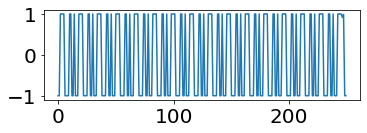

Max Value for real Image After Rescaling is = 1.0


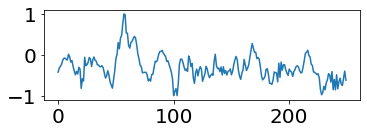

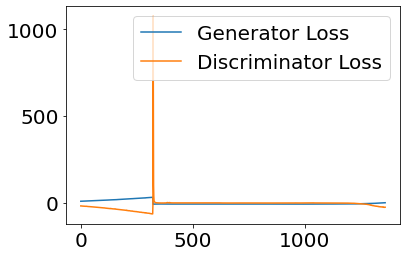

Epoch 1, step 6900: Generator loss: 2.273231621980667, discriminator loss: -25.388154697418212
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


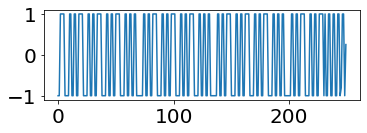

Max Value for real Image After Rescaling is = 1.0


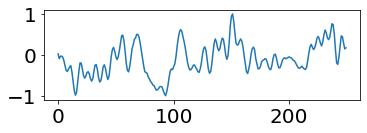

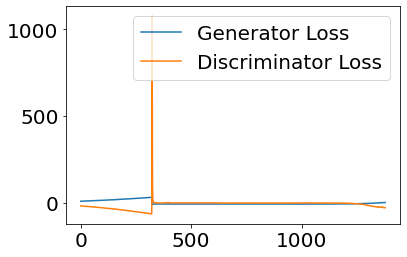

Epoch 1, step 7000: Generator loss: 3.7213435268402097, discriminator loss: -28.17336799621582
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


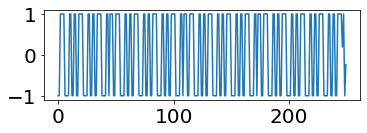

Max Value for real Image After Rescaling is = 1.0


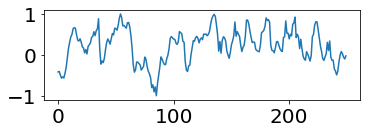

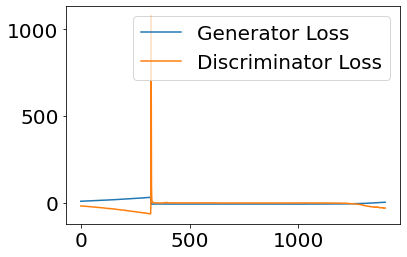

Epoch 1, step 7100: Generator loss: 5.390646538734436, discriminator loss: -29.407598037719726
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


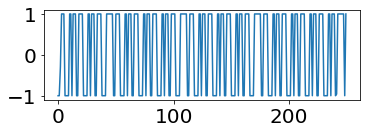

Max Value for real Image After Rescaling is = 1.0


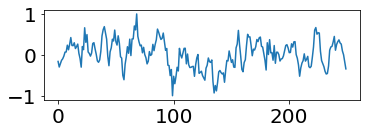

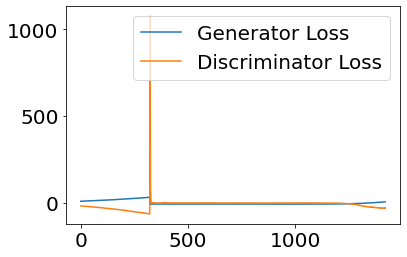

Epoch 1, step 7200: Generator loss: 7.268646340370179, discriminator loss: -31.21249849319458
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


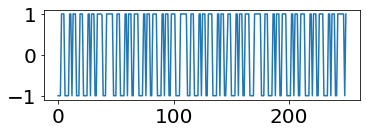

Max Value for real Image After Rescaling is = 1.0


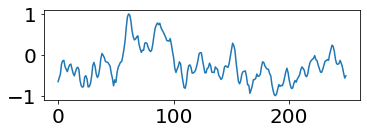

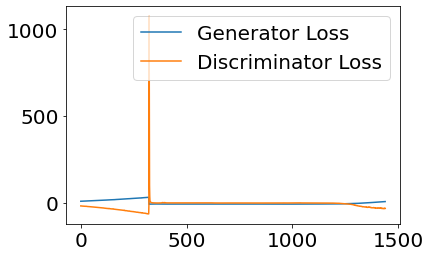

Epoch 1, step 7300: Generator loss: 8.945545454025268, discriminator loss: -33.02551815032959
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


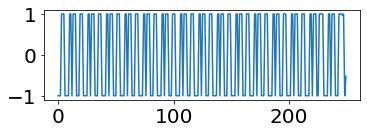

Max Value for real Image After Rescaling is = 1.0


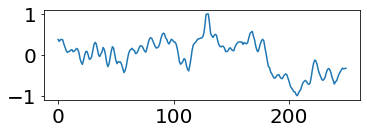

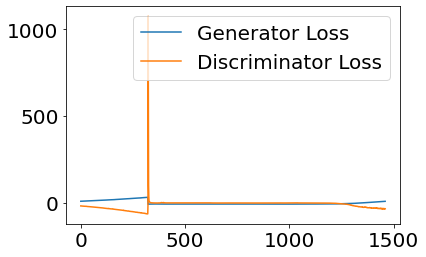

Epoch 1, step 7400: Generator loss: 10.602098712921142, discriminator loss: -35.91909437179565
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


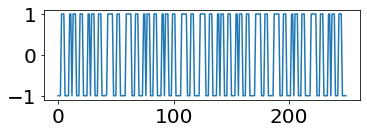

Max Value for real Image After Rescaling is = 1.0


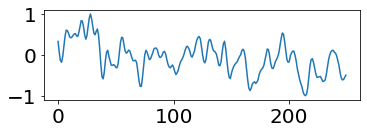

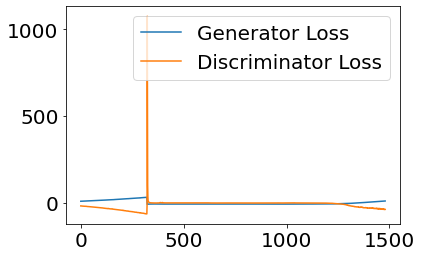

Epoch 1, step 7500: Generator loss: 12.351703901290893, discriminator loss: -37.19922582626343
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


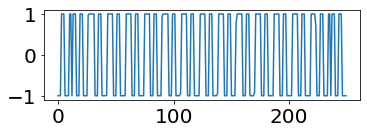

Max Value for real Image After Rescaling is = 1.0


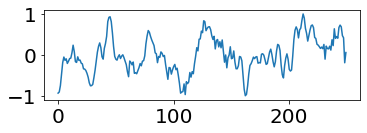

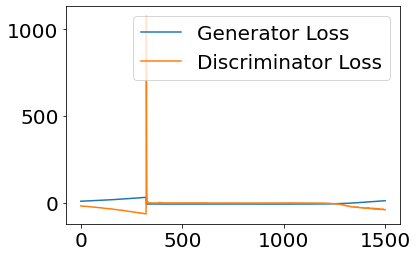

Epoch 1, step 7600: Generator loss: 14.071293678283691, discriminator loss: -40.425557937622074
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


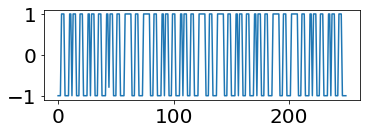

Max Value for real Image After Rescaling is = 1.0


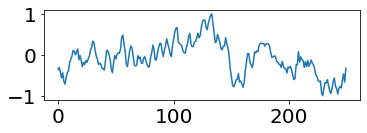

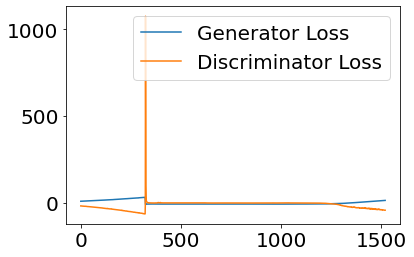

Epoch 1, step 7700: Generator loss: 15.859140186309814, discriminator loss: -41.89660694122315
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


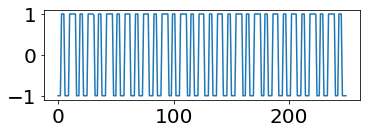

Max Value for real Image After Rescaling is = 1.0


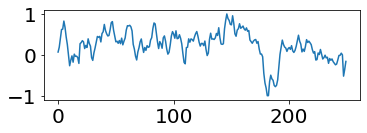

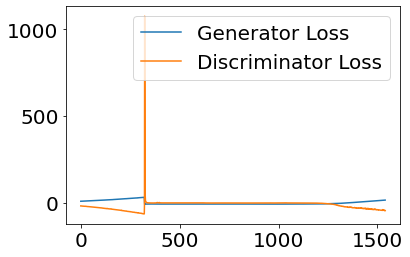

Epoch 1, step 7800: Generator loss: 17.588678340911866, discriminator loss: -44.55706230163574
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


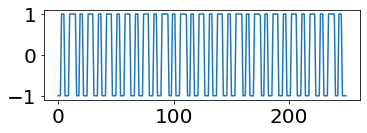

Max Value for real Image After Rescaling is = 1.0


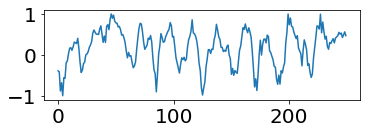

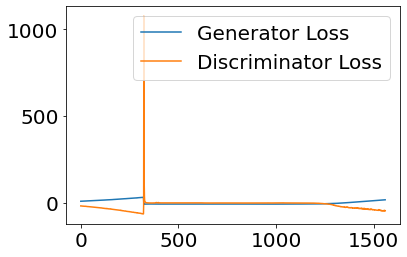

Epoch 1, step 7900: Generator loss: 19.282983570098878, discriminator loss: -47.10089374542236
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


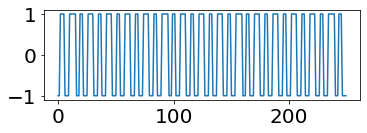

Max Value for real Image After Rescaling is = 1.0


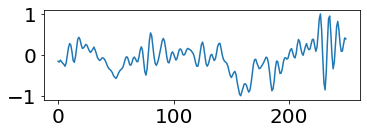

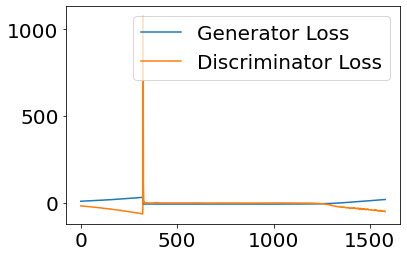

Epoch 1, step 8000: Generator loss: 20.892542037963867, discriminator loss: -49.15256912231445
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


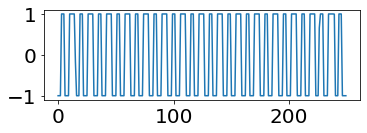

Max Value for real Image After Rescaling is = 1.0


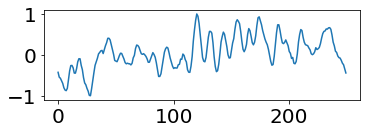

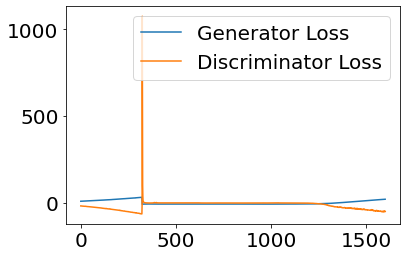

Epoch 1, step 8100: Generator loss: 22.58757776260376, discriminator loss: -51.94222255706787
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


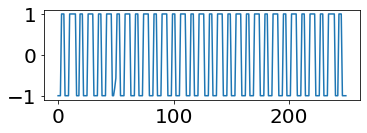

Max Value for real Image After Rescaling is = 1.0


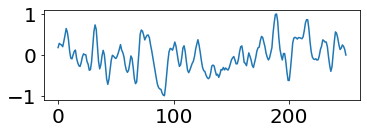

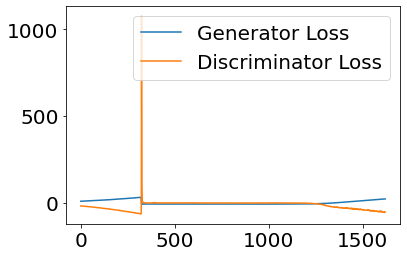

Epoch 1, step 8200: Generator loss: 24.383788776397704, discriminator loss: -55.34051219940186
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


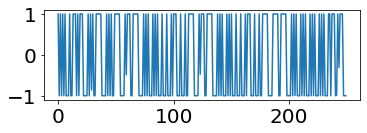

Max Value for real Image After Rescaling is = 1.0


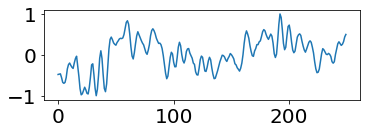

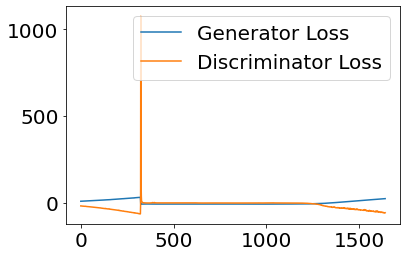

Epoch 1, step 8300: Generator loss: 26.00119939804077, discriminator loss: -57.02139717102051
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


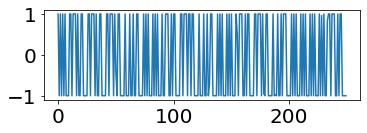

Max Value for real Image After Rescaling is = 1.0


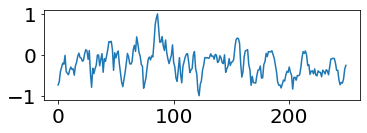

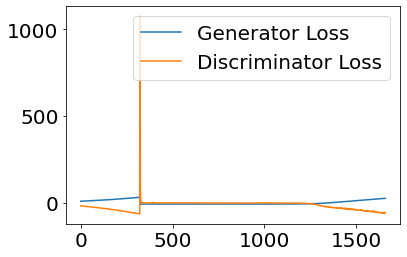

Epoch 2, step 8400: Generator loss: 27.563621673583985, discriminator loss: -60.16771385192871
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


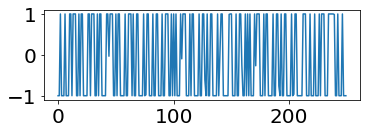

Max Value for real Image After Rescaling is = 1.0


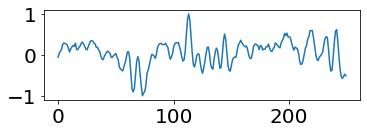

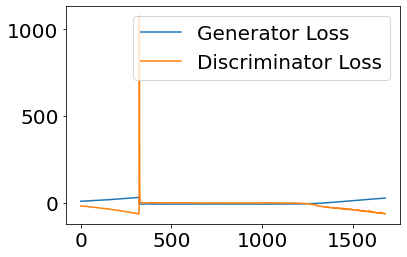

Epoch 2, step 8500: Generator loss: 29.22095672607422, discriminator loss: -62.8856770324707
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


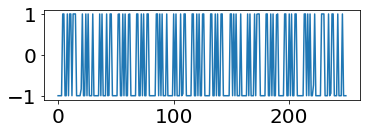

Max Value for real Image After Rescaling is = 1.0


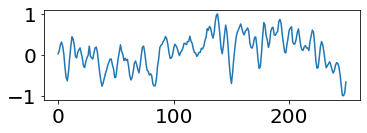

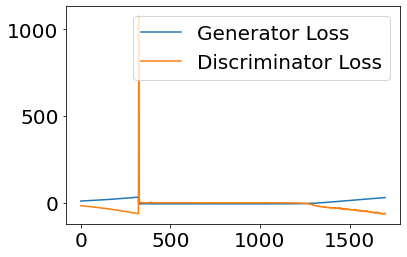

Epoch 2, step 8600: Generator loss: 30.876918144226075, discriminator loss: -61.22395072937012
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


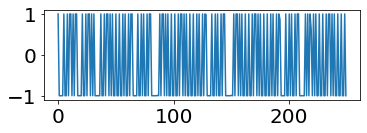

Max Value for real Image After Rescaling is = 1.0


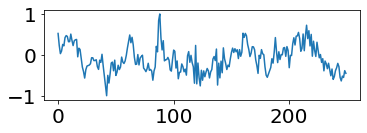

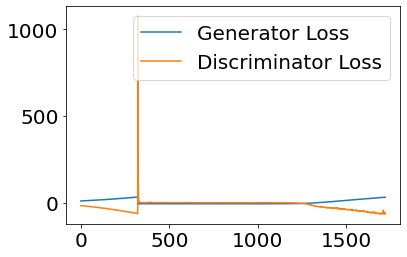

Epoch 2, step 8700: Generator loss: 32.49050861358643, discriminator loss: -64.84747009277343
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


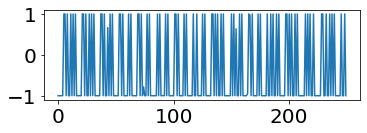

Max Value for real Image After Rescaling is = 1.0


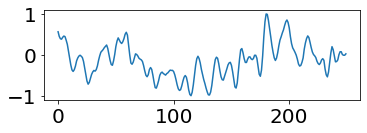

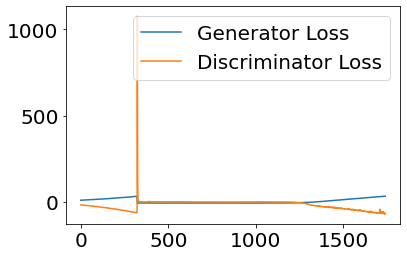

Epoch 2, step 8800: Generator loss: 34.06722957611084, discriminator loss: -68.62161617279052
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


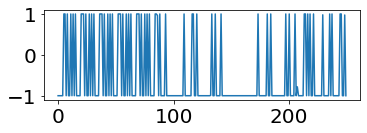

Max Value for real Image After Rescaling is = 1.0


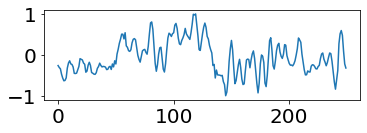

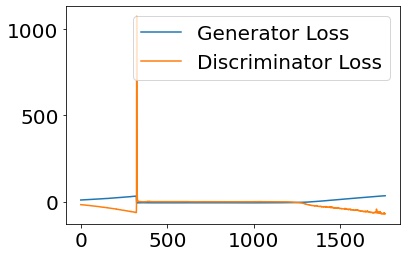

Epoch 2, step 8900: Generator loss: 35.39821617126465, discriminator loss: -67.94968032836914
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


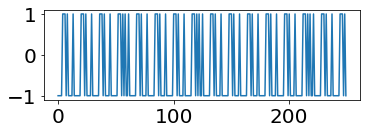

Max Value for real Image After Rescaling is = 1.0


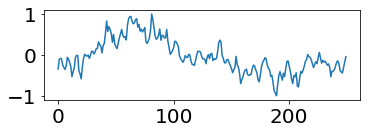

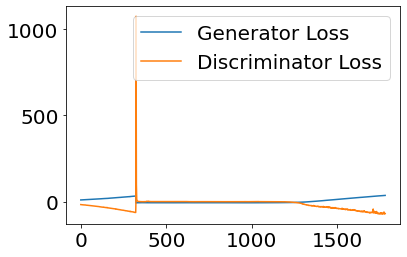

Epoch 2, step 9000: Generator loss: 37.29891246795654, discriminator loss: -73.36488670349121
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


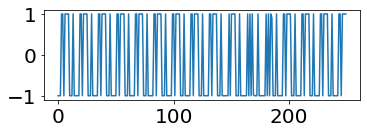

Max Value for real Image After Rescaling is = 1.0


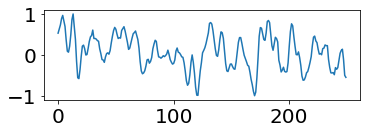

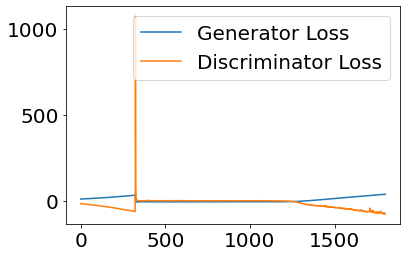

Epoch 2, step 9100: Generator loss: 39.170945167541504, discriminator loss: -77.84130401611328
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


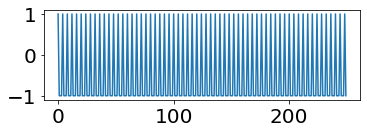

Max Value for real Image After Rescaling is = 1.0


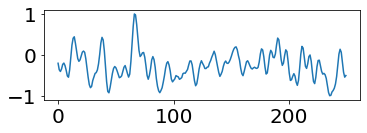

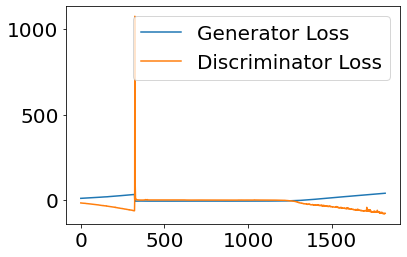

Epoch 2, step 9200: Generator loss: 40.94532962799072, discriminator loss: -81.57556411743164
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


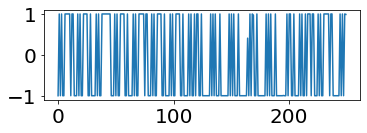

Max Value for real Image After Rescaling is = 1.0


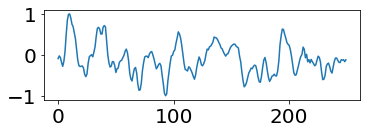

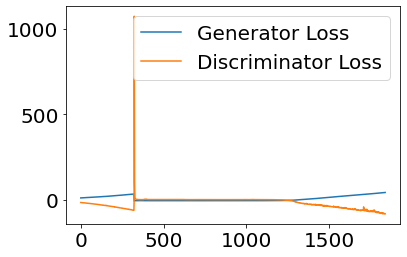

Epoch 2, step 9300: Generator loss: 42.71225063323975, discriminator loss: -84.38385635375977
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


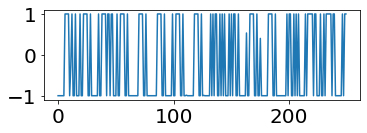

Max Value for real Image After Rescaling is = 1.0


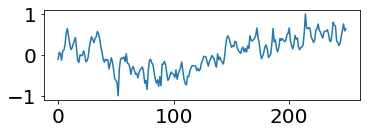

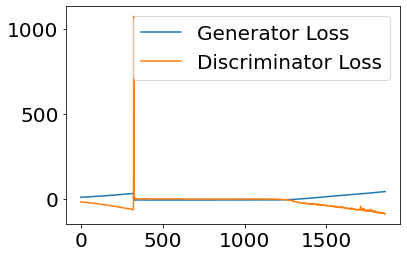

Epoch 2, step 9400: Generator loss: 44.39004493713379, discriminator loss: -87.80772827148438
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


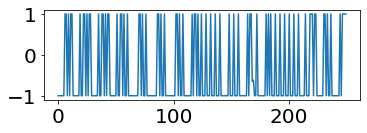

Max Value for real Image After Rescaling is = 1.0


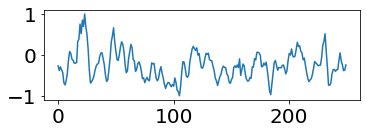

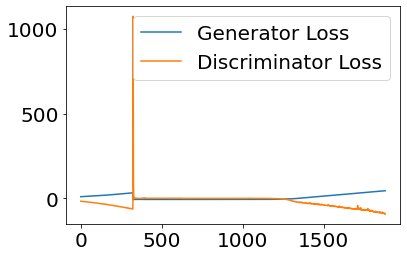

Epoch 2, step 9500: Generator loss: 46.07756576538086, discriminator loss: -88.7063924407959
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


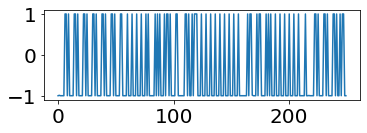

Max Value for real Image After Rescaling is = 1.0


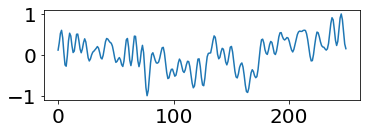

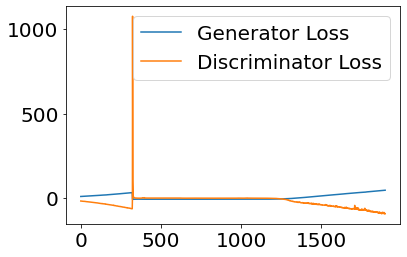

Epoch 2, step 9600: Generator loss: 47.81980655670166, discriminator loss: -94.4849910736084
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


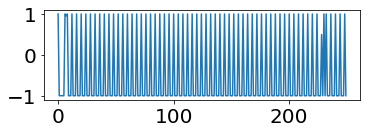

Max Value for real Image After Rescaling is = 1.0


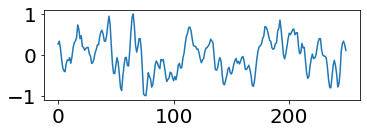

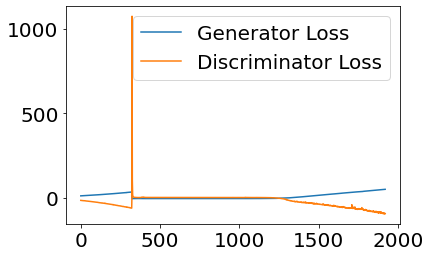

Epoch 2, step 9700: Generator loss: 49.660683135986325, discriminator loss: -97.39628936767578
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


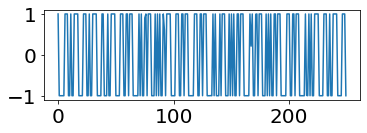

Max Value for real Image After Rescaling is = 1.0


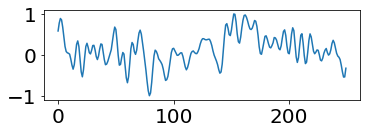

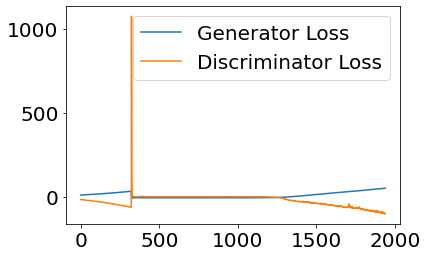

Epoch 2, step 9800: Generator loss: 51.37319202423096, discriminator loss: -101.1983275604248
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


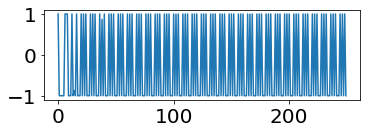

Max Value for real Image After Rescaling is = 1.0


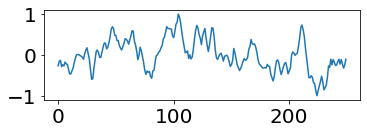

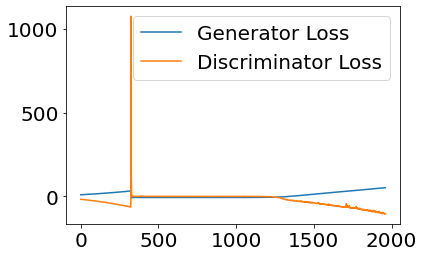

Epoch 2, step 9900: Generator loss: 52.99066009521484, discriminator loss: -103.83757926940918
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


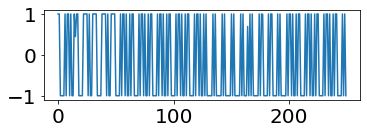

Max Value for real Image After Rescaling is = 1.0


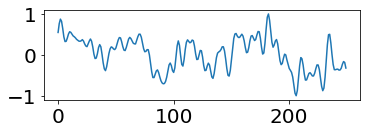

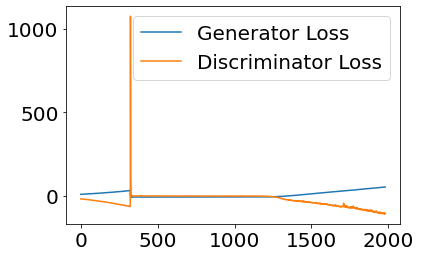

Epoch 2, step 10000: Generator loss: 54.87052013397217, discriminator loss: -108.4787734222412
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


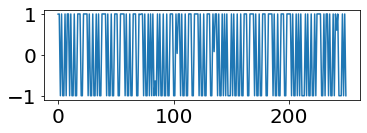

Max Value for real Image After Rescaling is = 1.0


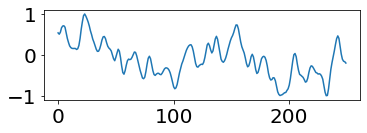

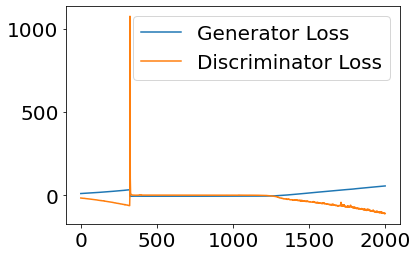

Epoch 2, step 10100: Generator loss: 56.47929756164551, discriminator loss: -111.56476341247559
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


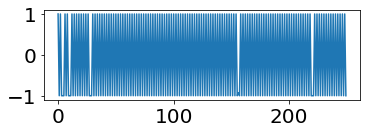

Max Value for real Image After Rescaling is = 1.0


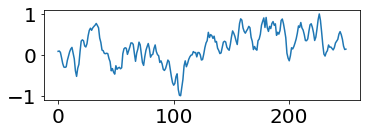

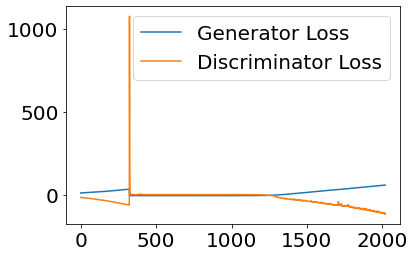

Epoch 2, step 10200: Generator loss: 58.10319126129151, discriminator loss: -117.80537673950195
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


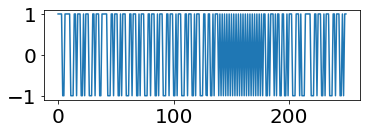

Max Value for real Image After Rescaling is = 1.0


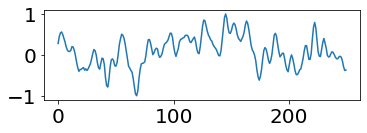

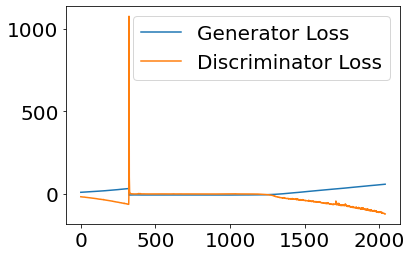

Epoch 2, step 10300: Generator loss: 59.786070327758786, discriminator loss: -119.33666709899903
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


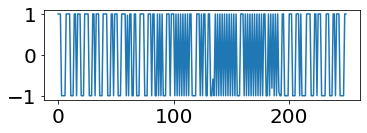

Max Value for real Image After Rescaling is = 1.0


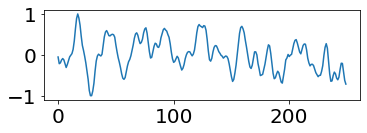

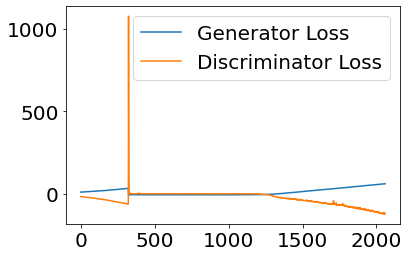

Epoch 2, step 10400: Generator loss: 61.46103683471679, discriminator loss: -117.28763290405273
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


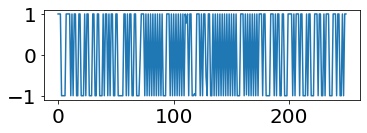

Max Value for real Image After Rescaling is = 1.0


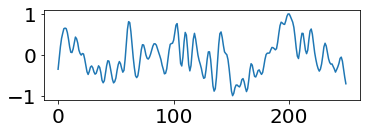

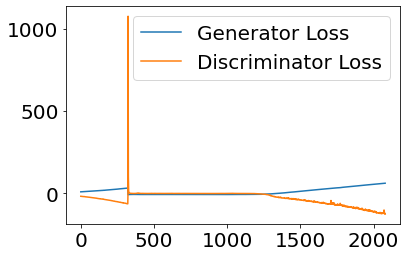

Epoch 2, step 10500: Generator loss: 63.10553260803223, discriminator loss: -127.0245645904541
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


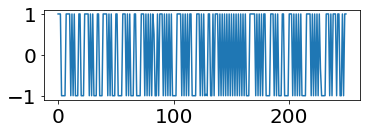

Max Value for real Image After Rescaling is = 1.0


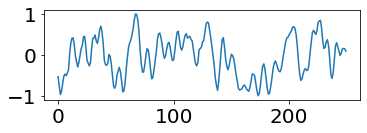

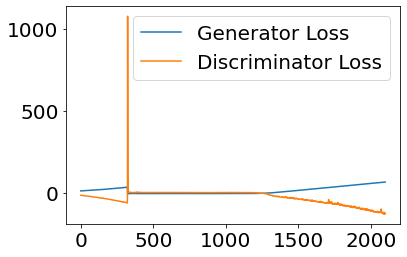

Epoch 2, step 10600: Generator loss: 64.69690822601318, discriminator loss: -128.65581329345704
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


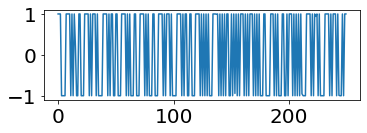

Max Value for real Image After Rescaling is = 1.0


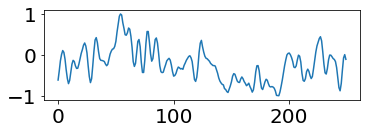

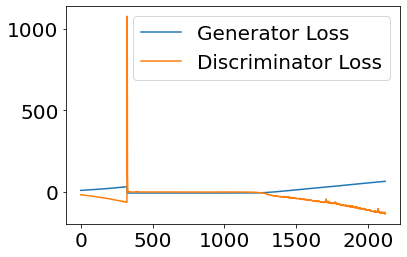

Epoch 2, step 10700: Generator loss: 66.33766052246094, discriminator loss: -132.78679054260255
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


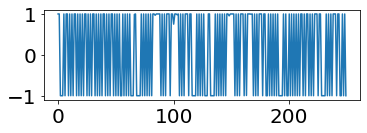

Max Value for real Image After Rescaling is = 1.0


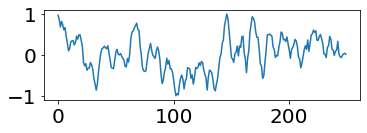

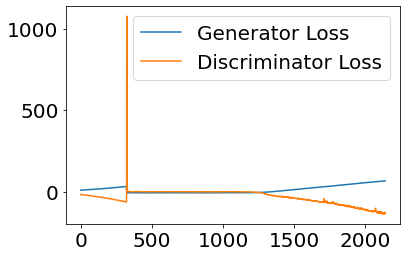

Epoch 2, step 10800: Generator loss: 67.9153018951416, discriminator loss: -138.1630422973633
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


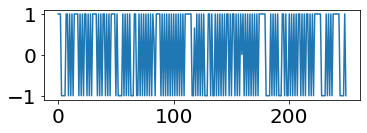

Max Value for real Image After Rescaling is = 1.0


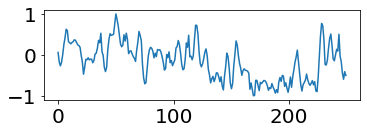

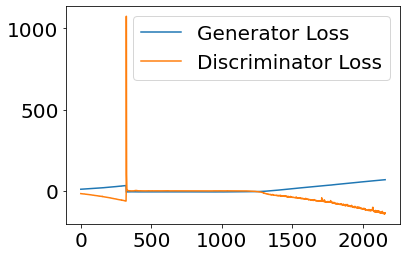

Epoch 2, step 10900: Generator loss: 69.58562652587891, discriminator loss: -143.72088790893554
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


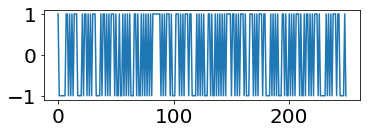

Max Value for real Image After Rescaling is = 1.0


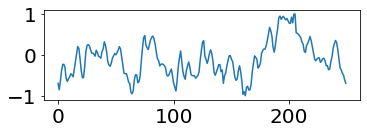

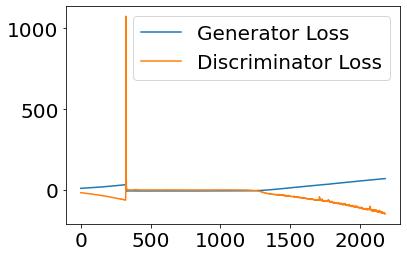

Epoch 2, step 11000: Generator loss: 71.24283424377441, discriminator loss: -147.4204685974121
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


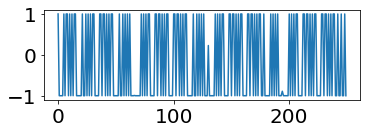

Max Value for real Image After Rescaling is = 1.0


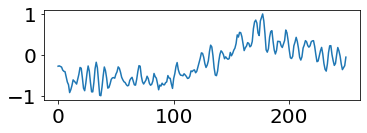

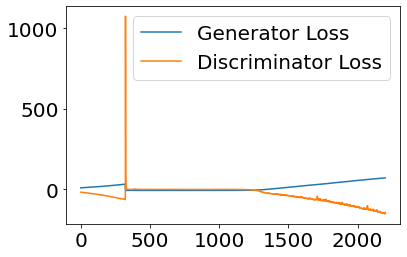

Epoch 2, step 11100: Generator loss: 72.83111610412598, discriminator loss: -150.5082681274414
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


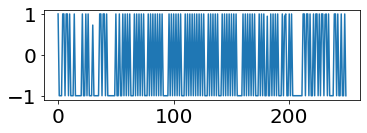

Max Value for real Image After Rescaling is = 1.0


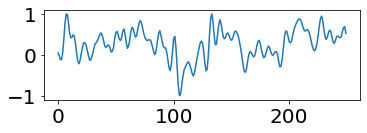

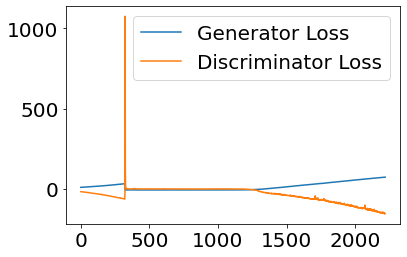

Epoch 2, step 11200: Generator loss: 74.33214889526367, discriminator loss: -152.0928340148926
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


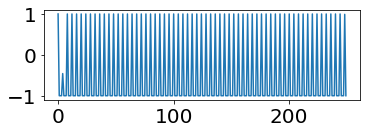

Max Value for real Image After Rescaling is = 1.0


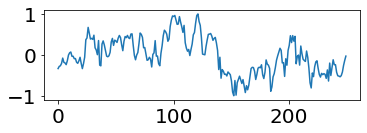

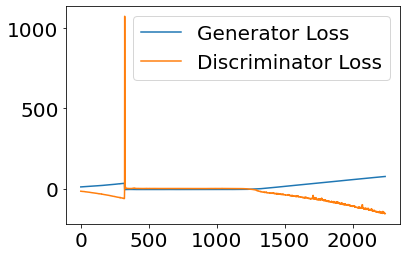

Epoch 2, step 11300: Generator loss: 75.94527473449708, discriminator loss: -158.5946580505371
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


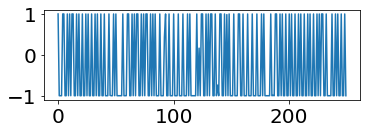

Max Value for real Image After Rescaling is = 1.0


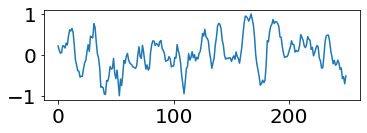

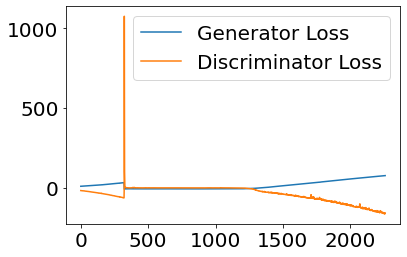

Epoch 2, step 11400: Generator loss: 77.5573762512207, discriminator loss: -160.9931494140625
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


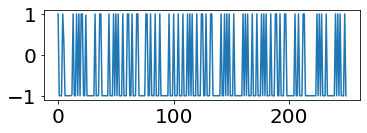

Max Value for real Image After Rescaling is = 1.0


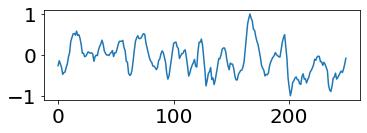

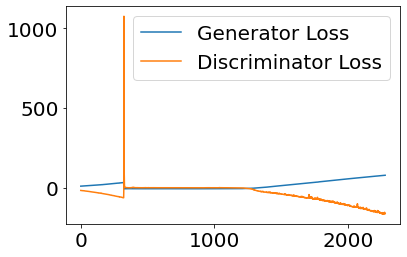

Epoch 2, step 11500: Generator loss: 79.23510520935059, discriminator loss: -166.19703552246094
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


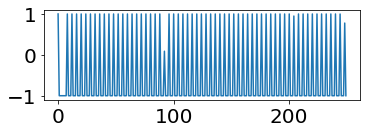

Max Value for real Image After Rescaling is = 1.0


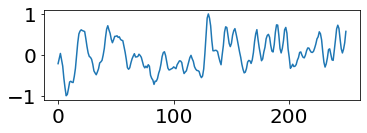

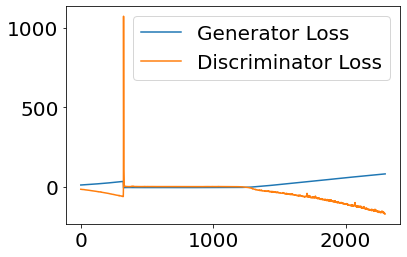

Epoch 2, step 11600: Generator loss: 80.87850311279297, discriminator loss: -171.86632202148436
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


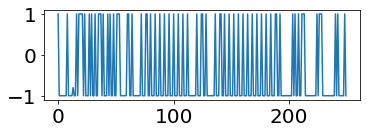

Max Value for real Image After Rescaling is = 1.0


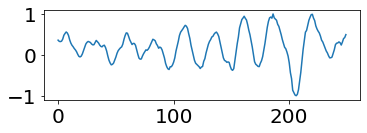

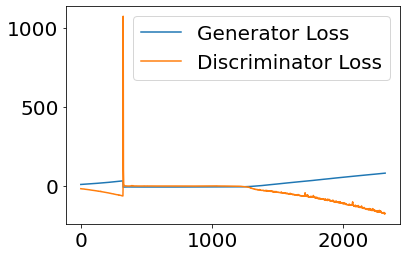

Epoch 2, step 11700: Generator loss: 82.4353636932373, discriminator loss: -173.3940901184082
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


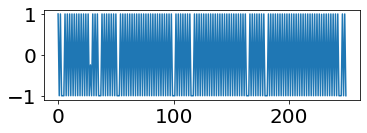

Max Value for real Image After Rescaling is = 1.0


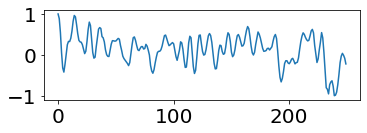

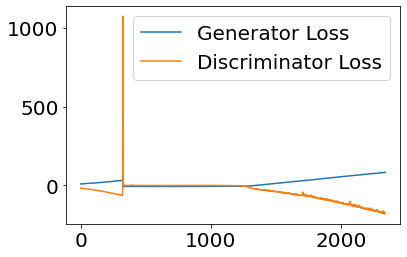

Epoch 2, step 11800: Generator loss: 84.1514389038086, discriminator loss: -180.95559158325196
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


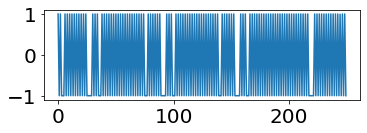

Max Value for real Image After Rescaling is = 1.0


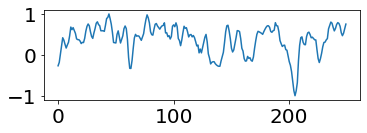

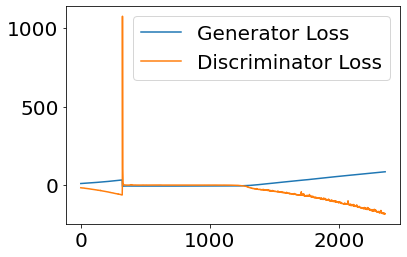

Epoch 2, step 11900: Generator loss: 85.71897804260254, discriminator loss: -185.1468505859375
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


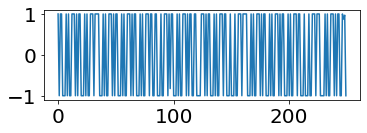

Max Value for real Image After Rescaling is = 1.0


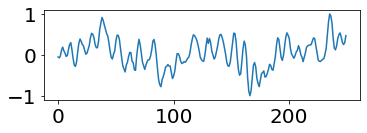

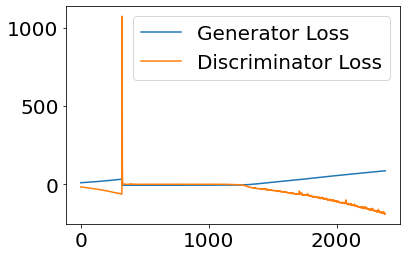

Epoch 2, step 12000: Generator loss: 87.325771484375, discriminator loss: -189.86988906860353
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


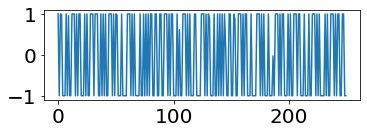

Max Value for real Image After Rescaling is = 1.0


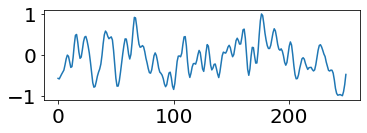

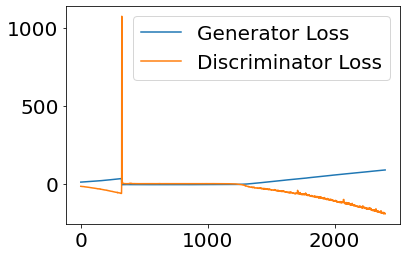

Epoch 2, step 12100: Generator loss: 88.8304832458496, discriminator loss: -193.1685771179199
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


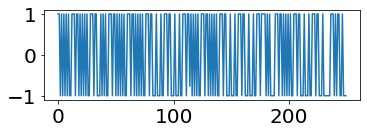

Max Value for real Image After Rescaling is = 1.0


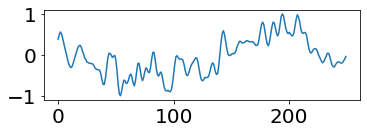

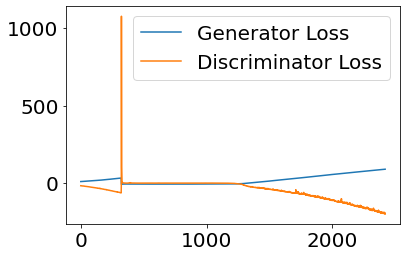

Epoch 2, step 12200: Generator loss: 90.24466323852539, discriminator loss: -191.89075790405275
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


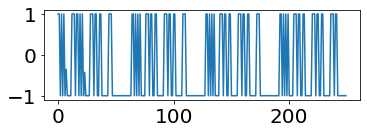

Max Value for real Image After Rescaling is = 1.0


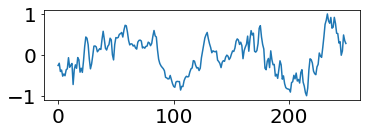

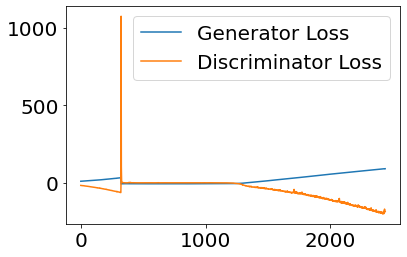

Epoch 2, step 12300: Generator loss: 91.61546455383301, discriminator loss: -170.0861908340454
Max Value for fake Image is = 1.0
Max Value for real Image is = 1.0


In [ ]:
import pdb
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=int(data.shape[0]/batch_size))

cur_step = 0
display_step = 100
generator_losses = []
crit_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
crit_fake_pred = False
crit_real_pred = False

import matplotlib.pyplot as plt

#print(f' Length of all the Indexes is = {len(allIdxs)}')

for epoch in range(n_epochs):
    # Dataloader returns the batches

    for train_index, test_index in skf.split(data, target):
        real = data[test_index]        
        real = real.detach().cpu().numpy()
        real = real.reshape(real.shape[0], real.shape[2])
        #print(f'real.shape = {real.shape}')
        maxVals = np.max(real, axis=1).reshape(batch_size, 1)
        #print(f'maxVals.shape = {maxVals.shape}')
        minVals = np.min(real, axis=1).reshape(batch_size, 1)
        #print(f'minVals.shape = {minVals.shape}')
        OldRange = np.subtract(maxVals, minVals).reshape(batch_size, 1) 
        #print(f'OldRange.shape = {OldRange.shape}') 
        NewRange = np.repeat([[2]], batch_size, axis=0)
        #print(f'NewRange.shape = {NewRange.shape}')
        #image_one_hot_labels.repeat(1, 1, image_size)
        # NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
        real = ((np.subtract(real, minVals) * NewRange) / OldRange) - np.repeat([[1]], batch_size, axis=0)        
        real = real.reshape(real.shape[0], 1, real.shape[1])
        ##print(f'real.shape = {real.shape}')
        #print(f'real signal Min = {np.min(real)}')
        #print(f'real signal Max = {np.max(real)}')
        real = torch.from_numpy(real)
        '''maxReal = torch.max(torch.abs(real))
        print(f'maxReal = {torch.max(maxReal)}')
        print(f'maxReal/2 = {torch.max(maxReal)/2}')
        real = torch.divide(real, maxReal/2)
        print(f'real signal Min = {torch.min(real)}')
        print(f'real signal Max = {torch.max(real)}')

        real = torch.subtract(real, 1)

        print(f'real signal Min = {torch.min(real)}')
        print(f'real signal Max = {torch.max(real)}')'''

        labels = target[test_index]
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)        

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None]
        #print(image_one_hot_labels.shape)
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, image_size)
        '''print(f'image_one_hot_labels Min = {torch.min(image_one_hot_labels)}')
        print(f'image_one_hot_labels Max = {torch.max(image_one_hot_labels)}')'''
        #print(image_one_hot_labels.shape)
        #image_one_hot_labels = one_hot_labels[:, :, None, None]
        #image_one_hot_labels = image_one_hot_labels.repeat(1, 1, image_size,image_size)

        ### Update discriminator ###
        # Zero out the discriminator gradients
        crit_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        noise_and_labels = torch.cat([fake_noise, one_hot_labels], dim=1)
        #print(f'noise_and_labels = {noise_and_labels.shape}')
        fake = gen(noise_and_labels)

        
        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        # print(f'fake.shape = {fake.shape}')
        assert tuple(fake.shape) == (len(real), 1, image_size)

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as crit_fake_pred
        #        3) Get the discriminator's prediction on the reals as crit_real_pred
        
        #print(fake)
        #print(real)

        #one_hot_labels = np.reshape(one_hot_labels, (one_hot_labels.shape[0], 1, one_hot_labels.shape[1]))
        #print(f'one_hot_labels.shape = {one_hot_labels.shape}')
        fake_image_and_labels = torch.cat([fake, image_one_hot_labels], dim=1)
        #print(f'fake_image_and_labels.shape = {fake_image_and_labels.shape}')        
        real_image_and_labels = torch.cat([real, image_one_hot_labels], dim=1).to(torch.float32)
        '''print(f'fake_image_and_labels Max = {torch.max(fake_image_and_labels)}')
        print(f'real_image_and_labelse Max = {torch.max(real_image_and_labels)}')
        print(f'fake_image_and_labels Min = {torch.min(fake_image_and_labels)}')
        print(f'real_image_and_labels Min = {torch.min(real_image_and_labels)}')'''
        #print(f'real_image_and_labels.shape = {real_image_and_labels.shape}')
        crit_fake_pred = crit(fake_image_and_labels)
        crit_real_pred = crit(real_image_and_labels)
        
        # Make sure shapes are correct 
        '''print(f'fake.shape: {fake_image_and_labels.shape}')
        print(f'one_hot_labels.shape: {one_hot_labels.shape}')
        print(f'image_one_hot_labels.shape: {image_one_hot_labels.shape}')
        print(f'real.shape: {real_image_and_labels.shape}')'''
     
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], image_size) ### Change
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], image_size) ### Change
        # Make sure that enough predictions were made
        assert len(crit_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(crit_fake_pred.shape) == tuple(crit_real_pred.shape)
        
        epsilon = torch.rand(len(real), 1, 1, device=device, requires_grad=True)
        gradient = get_gradient(crit, real_image_and_labels, fake_image_and_labels.detach(), epsilon)
        gp = gradient_penalty(gradient)
        crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)                
        crit_loss.backward(retain_graph=True)
        crit_opt.step() 

        # Keep track of the average discriminator loss
        crit_losses += [crit_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        crit_fake_pred = crit(fake_image_and_labels)
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(crit_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {crit_mean}")
            print(f'Max Value for fake Image is = {torch.max(fake)}')
            print(f'Max Value for real Image is = {torch.max(real)}')
            show_tensor_signal(fake)
            #real = (real + 1)*(maxVal/2)
            print(f'Max Value for real Image After Rescaling is = {torch.max(real)}')
            show_tensor_signal(real)
            step_bins = 5
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(crit_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1
        #print(f'cur_step = {cur_step}')